### Titanic Survival  -- Decision Tree Model

Here we will import data on Titanic passengers that either survived or died when the ship sank in 1912.  The Kaggle file train.csv will be used to develop the decision tree model and test.csv will be used to evaluate model performance. 

### Preliminaries
Load in the required library: recursive partitioning and import the training data from its origin .csv file into an R dataframe.  Inspect the contents of the data frame.

In [1]:
# Load the recursive partitioning module that will be used to generate decision tree.
library(rpart)

# Import train.csv into data frame
Titanic.train<-read.csv("Datasets/Titanic/train.csv", header=TRUE, sep=",")
#head(Titanic.train)

# Import train.csv into data frame, this is our test data for which the actual survived labels are unknown.
Titanic.test<-read.csv("Datasets/Titanic/test.csv", header=TRUE, sep=",")
#head(Titanic.test)

# .train and .test sets will be combined, temporarily, for pre-formatting to be performed on them both simultaneously
# to ensure consistency.

# Generate indices lists for each so that they can be separated afterwards.
train.set.end.index <- nrow(Titanic.train)
train.set.indices <- 1:train.set.end.index
test.set.indices <- (train.set.end.index + 1):(train.set.end.index + nrow(Titanic.test))

# Combine the data to make data cleaning easier
Survived <- Titanic.train$Survived

In [2]:
# Exclude 'Survived' column from training set and combine with test set
Titanic.combined <- rbind(Titanic.train[,!(names(Titanic.train) %in% c('Survived'))], Titanic.test)

# Report dimension of combined dataframe
dim(Titanic.combined)

# Show the top few lines of the combined dataframe
head(Titanic.combined)

[1] 1309   11

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<fct>
1,1,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,5,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,6,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


In [3]:
# Cast Survived as factor/category levels from boolean vector
Survived <- as.factor(Survived)

# Cast Pclass as factor
Titanic.combined$Pclass <- as.factor(Titanic.combined$Pclass)

In [4]:
# Show how the training dataframe is structured
str(Titanic.combined)

'data.frame':	1309 obs. of  11 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 929 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 187 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


In [5]:
# Fill in NAs in Embarked column with Mode
x <- Titanic.combined$Embarked
y <- table(x)
mode <- names(y)[which(y==max(y))]
Titanic.combined$Embarked[Titanic.combined$Embarked == ""] <- mode
Titanic.combined$Embarked <- factor(Titanic.combined$Embarked)
levels(Titanic.combined$Embarked) <-c("Cherbourg", "Queenstown", "Southampton")

In [6]:
levels(Titanic.combined$Embarked)

[1] "Cherbourg"   "Queenstown"  "Southampton"

In [7]:
# Set any NA's in Fare column to zero.
Titanic.combined$Fare[is.na(Titanic.combined$Fare)] <- 0.0
mean(Titanic.combined$Fare)

[1] 33.27004

In [8]:
# Engineer a new feature to track which Age values are missing
Titanic.combined$AgeMissing <- as.factor(ifelse(is.na(Titanic.combined$Age), "Y", "N"))

# Insert median value for NAs in Age column
Titanic.combined$Age[is.na(Titanic.combined$Age)] <- median(Titanic.combined$Age, na.rm=TRUE)

# Change levels of Survived and Embarked factors to more meaningful values...
levels(Survived)<-c("Dead", "Survived")

# Examine the modified columns of data frame
table(Survived)
str(Survived)
str(Titanic.combined[,c('Embarked')])
str(Titanic.combined[,c('AgeMissing')])

Survived
    Dead Survived 
     549      342 

 Factor w/ 2 levels "Dead","Survived": 1 2 2 2 1 1 1 1 2 2 ...
 Factor w/ 3 levels "Cherbourg","Queenstown",..: 3 1 3 3 3 2 3 3 3 1 ...
 Factor w/ 2 levels "N","Y": 1 1 1 1 1 2 1 1 1 1 ...


In [9]:
# Count the number of family members, including spouse, parents, children each passenger reported
Titanic.combined$FamilySize <- 1 + Titanic.combined$SibSp + Titanic.combined$Parch

# Combine SibSp and Parch categories into simple yes/no for "HasFamily"
Titanic.combined$HasFamily <- as.factor(Titanic.combined$FamilySize > 1)

# Strip off room number from values in Cabin column to reduce number of levels for the category
Titanic.combined$CabinType <- as.factor(substr(as.character(Titanic.combined$Cabin),1,1))

# Make separate category to identify children
Titanic.combined$IsChild <- as.factor(Titanic.combined$Age <= 12)

# Make separate category to identify seniors
Titanic.combined$IsSenior <- as.factor(Titanic.combined$Age >= 50)

# Make additional numerical feature: ratio of Fare:Age
Titanic.combined$FareAgeRatio <- Titanic.combined$Fare / Titanic.combined$Age

# Apply log transform of Fare:Age and replace -Inf = log(0) values with median
Titanic.combined$log.FareAgeRatio <- log(Titanic.combined$FareAgeRatio)
Titanic.combined$log.FareAgeRatio[Titanic.combined$log.FareAgeRatio == -Inf] <- 
    median(Titanic.combined$log.FareAgeRatio)

# Make additional numerical feature: ratio of Age:FamilySize
Titanic.combined$AgeFamilySizeRatio <- Titanic.combined$Age / Titanic.combined$FamilySize

# Apply log transform of Age:FamilySize and replace -Inf = log(0) values with median
Titanic.combined$log.AgeFamilySizeRatio <- log(Titanic.combined$AgeFamilySizeRatio)
Titanic.combined$log.AgeFamilySizeRatio[Titanic.combined$log.AgeFamilySizeRatio == -Inf] <- 
    median(Titanic.combined$log.AgeFamilySizeRatio)

# Make additional numerical feature: ratio of Fare:FamilySize
Titanic.combined$FareFamilySizeRatio <- Titanic.combined$Fare / Titanic.combined$FamilySize

# Apply log transform of Fare:FamilySize and replace -Inf = log(0) values with median
Titanic.combined$log.FareFamilySizeRatio <- log(Titanic.combined$FareFamilySizeRatio)
Titanic.combined$log.FareFamilySizeRatio[Titanic.combined$log.FareFamilySizeRatio == -Inf] <- 
    median(Titanic.combined$log.FareFamilySizeRatio)

# Make additional numerical feature: Age:Pclass
Titanic.combined$AgePclassRatio <- Titanic.combined$Age / as.numeric(Titanic.combined$Pclass)

# Apply log transform of Age:Pclass and replace -Inf = log(0) values with median
Titanic.combined$log.AgePclassRatio <- log(Titanic.combined$AgePclassRatio) 
Titanic.combined$log.AgePclassRatio[Titanic.combined$log.AgePclassRatio == -Inf] <- 
    median(Titanic.combined$log.AgePclassRatio)

# Make additional numerical feature Fare:Pclass
Titanic.combined$FarePclassRatio <- Titanic.combined$Fare / as.numeric(Titanic.combined$Pclass)

# Apply log transform of Fare:Pclass and replace -Inf = log(0) values with median
Titanic.combined$log.FarePclassRatio <- log(Titanic.combined$FarePclassRatio) 
Titanic.combined$log.FarePclassRatio[Titanic.combined$log.FarePclassRatio == -Inf] <- 
    median(Titanic.combined$log.FarePclassRatio)

# Make additional numerical feature FamilySize:Pclass
Titanic.combined$FamilySizePclassRatio <- Titanic.combined$FamilySize / as.numeric(Titanic.combined$Pclass)

# Apply log transform of FamilySize:Pclass and replace -Inf = log(0) values with median
Titanic.combined$log.FamilySizePclassRatio <- log(Titanic.combined$FamilySizePclassRatio) 
Titanic.combined$log.FamilySizePclassRatio[Titanic.combined$log.FamilySizePclassRatio == -Inf] <- 
    median(Titanic.combined$log.FamilySizePclassRatio)

str(Titanic.combined[,c("FamilySize", "HasFamily", "CabinType", "AgeMissing", "IsChild", "IsSenior", 
                        "FareAgeRatio", "log.FareAgeRatio", "AgeFamilySizeRatio", "log.AgeFamilySizeRatio",
                        "FareFamilySizeRatio", "log.FareFamilySizeRatio", "AgePclassRatio", "log.AgePclassRatio",
                        "FarePclassRatio", "log.FarePclassRatio", "FamilySizePclassRatio", "log.FamilySizePclassRatio")])

'data.frame':	1309 obs. of  18 variables:
 $ FamilySize               : num  2 2 1 2 1 1 1 5 3 2 ...
 $ HasFamily                : Factor w/ 2 levels "FALSE","TRUE": 2 2 1 2 1 1 1 2 2 2 ...
 $ CabinType                : Factor w/ 9 levels "","A","B","C",..: 1 4 1 4 1 1 6 1 1 1 ...
 $ AgeMissing               : Factor w/ 2 levels "N","Y": 1 1 1 1 1 2 1 1 1 1 ...
 $ IsChild                  : Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 1 1 1 2 1 1 ...
 $ IsSenior                 : Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 1 1 2 1 1 1 ...
 $ FareAgeRatio             : num  0.33 1.876 0.305 1.517 0.23 ...
 $ log.FareAgeRatio         : num  -1.11 0.629 -1.188 0.417 -1.47 ...
 $ AgeFamilySizeRatio       : num  11 19 26 17.5 35 28 54 0.4 9 7 ...
 $ log.AgeFamilySizeRatio   : num  2.4 2.94 3.26 2.86 3.56 ...
 $ FareFamilySizeRatio      : num  3.62 35.64 7.92 26.55 8.05 ...
 $ log.FareFamilySizeRatio  : num  1.29 3.57 2.07 3.28 2.09 ...
 $ AgePclassRatio           : num  7.33 38 8.67 35 11.67 .

In [10]:

sum(is.nan(Titanic.combined$log.FareAgeRatio))
sum(is.na(Titanic.combined$log.FareAgeRatio))
sum(Titanic.combined$log.FareAgeRatio == -Inf)
sum(Titanic.combined$log.FareAgeRatio == Inf)
sum(Titanic.combined$log.FareAgeRatio < 0)
sum(Titanic.combined$log.FareAgeRatio > 0)
min(Titanic.combined$log.FareAgeRatio)
max(Titanic.combined$log.FareAgeRatio)

[1] 0

[1] 0

[1] 0

[1] 0

[1] 908

[1] 398

[1] -2.280294

[1] 5.104297

In [ ]:
sum(is.nan(Titanic.combined$log.AgeFamilySizeRatio))
sum(is.na(Titanic.combined$log.AgeFamilySizeRatio))
sum(Titanic.combined$log.AgeFamilySizeRatio == Inf)
sum(Titanic.combined$log.AgeFamilySizeRatio == -Inf)
sum(Titanic.combined$log.AgeFamilySizeRatio < 0)
sum(Titanic.combined$log.AgeFamilySizeRatio > 0)
min(Titanic.combined$log.AgeFamilySizeRatio)
max(Titanic.combined$log.AgeFamilySizeRatio)
median(Titanic.combined$log.AgeFamilySizeRatio)

In [ ]:
sum(is.nan(Titanic.combined$log.FareFamilySizeRatio))
sum(is.na(Titanic.combined$log.FareFamilySizeRatio))
sum(Titanic.combined$log.FareFamilySizeRatio == Inf)
sum(Titanic.combined$log.FareFamilySizeRatio == -Inf)
sum(Titanic.combined$log.FareFamilySizeRatio < 0)
sum(Titanic.combined$log.FareFamilySizeRatio > 0)
min(Titanic.combined$log.FareFamilySizeRatio)
max(Titanic.combined$log.FareFamilySizeRatio)
median(Titanic.combined$log.FareFamilySizeRatio)

In [ ]:
sum(is.nan(Titanic.combined$log.AgePclassRatio))
sum(is.na(Titanic.combined$log.AgePclassRatio))
sum(Titanic.combined$log.AgePclassRatio == Inf)
sum(Titanic.combined$log.AgePclassRatio == -Inf)
sum(Titanic.combined$log.AgePclassRatio < 0)
sum(Titanic.combined$log.AgePclassRatio > 0)
min(Titanic.combined$log.AgePclassRatio)
max(Titanic.combined$log.AgePclassRatio)
median(Titanic.combined$log.AgePclassRatio)

In [ ]:
levels(Titanic.combined$CabinType)
sum(Titanic.combined$CabinType == "")

## Assess Relative "Importance" of All Features
First, all categorical features (sex, passenger class, port of embarkation) must be discretized as boolean vectors for each of their categories.  Next, use `randomForest` to calculate decrease in Accuracy and Gini similarity with inclusion/exclusion of each candidate feature.  Sort result statistics in decending order and visualize as barplot.

In [11]:
# Load the randomForest library
library(randomForest)
features <- c("Survived", "Age", "SibSp", "Parch", 
              "Fare", "FamilySize", "age_missing",
              "FareAgeRatio", "log.FareAgeRatio",
              "AgeFamilySizeRatio", "log.AgeFamilySizeRatio",
              "FareFamilySizeRatio", "log.FareFamilySizeRatio",
              "AgePclassRatio", "log.AgePclassRatio",
              "FarePclassRatio", "log.FarePclassRatio", 
              "FamilySizePclassRatio", "log.FamilySizePclassRatio",
              "pclass_one", "pclass_two", "pclass_three", 
              "embarked_q", "embarked_s", "embarked_c", 
              "sex_m", "sex_f", 
              "cab_null", "cab_a", "cab_b", "cab_c", "cab_d", "cab_e", "cab_f", "cab_g", "cab_t",
              "has_fam", "is_child", "is_senior"
            )
              #"IsChild", "IsSenior", "HasFamily")

# Discretize AgeMissing feature
Titanic.combined$age_missing <- 0

# Numerically discretize (1,0) AgeMissing: "Y", "N"
Titanic.combined[Titanic.combined$AgeMissing == "Y", "age_missing"] <- 1

# Discretize Pclass feature
# initialize a column for each level
Titanic.combined$pclass_one <- 0
Titanic.combined$pclass_two <- 0
Titanic.combined$pclass_three <- 0

# Numerically discretize (1,0) Pclass: 1, 2, 3
Titanic.combined[Titanic.combined$Pclass == 1, "pclass_one"] <- 1
Titanic.combined[Titanic.combined$Pclass == 2, "pclass_two"] <- 1
Titanic.combined[Titanic.combined$Pclass == 3, "pclass_three"] <- 1

# Numerically discretize (1,0) Embarked features: "Unknown",
# "Cherbourg", "Queenstown", "Southampton"
Titanic.combined$embarked_q <- 0
Titanic.combined$embarked_s <- 0
Titanic.combined$embarked_c <- 0
Titanic.combined[Titanic.combined$Embarked == "Queenstown", "embarked_q"] <- 1
Titanic.combined[Titanic.combined$Embarked == "Southampton", "embarked_s"] <- 1
Titanic.combined[Titanic.combined$Embarked == "Cherbourg", "embarked_c"] <- 1

# Numerically discretize (1,0) Sex feature: "male", "female"
Titanic.combined$sex_m <- 0
Titanic.combined$sex_f <- 0
Titanic.combined[Titanic.combined$Sex == "male", "sex_m"] <- 1
Titanic.combined[Titanic.combined$Sex == "female", "sex_f"] <- 1

# Numerically discretize } CabinType: '' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'T' 
Titanic.combined$cab_null <- 0
Titanic.combined$cab_a <- 0
Titanic.combined$cab_b <- 0
Titanic.combined$cab_c <- 0
Titanic.combined$cab_d <- 0
Titanic.combined$cab_e <- 0
Titanic.combined$cab_f <- 0
Titanic.combined$cab_g <- 0
Titanic.combined$cab_t <- 0
Titanic.combined[Titanic.combined$CabinType == '', "cab_null"] <- 1
Titanic.combined[Titanic.combined$CabinType == 'A', "cab_a"] <- 1
Titanic.combined[Titanic.combined$CabinType == 'B', "cab_b"] <- 1
Titanic.combined[Titanic.combined$CabinType == 'C', "cab_c"] <- 1
Titanic.combined[Titanic.combined$CabinType == 'D', "cab_d"] <- 1
Titanic.combined[Titanic.combined$CabinType == 'E', "cab_e"] <- 1
Titanic.combined[Titanic.combined$CabinType == 'F', "cab_f"] <- 1
Titanic.combined[Titanic.combined$CabinType == 'G', "cab_g"] <- 1
Titanic.combined[Titanic.combined$CabinType == 'T', "cab_t"] <- 1

# Numerically discretize {0,1} HasFamily: TRUE, FALSE
Titanic.combined$has_fam <- 0
Titanic.combined[Titanic.combined$HasFamily == TRUE, "has_fam"] <- 1

# Numerically discretize {0,1} IsChild: TRUE, FALSE
Titanic.combined$is_child <- 0
Titanic.combined[Titanic.combined$IsChild == TRUE, "is_child"] <- 1

# Numerically discretize {0,1} IsSenior: TRUE, FALSE
Titanic.combined$is_senior <- 0
Titanic.combined[Titanic.combined$IsSenior == TRUE, "is_senior"] <- 1

#summary(Titanic.combined)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.



## Extract out titles from Names to use as another categorical predictor.

In [12]:
# Load the required library
library(stringr)
# Split name into last, title, and name
name_list <- str_split(Titanic.combined$Name, pattern="\\. |, ")
names_df <- data.frame(Reduce(rbind, name_list), stringsAsFactors=FALSE)
names(names_df) <- c("Last", "Title", "First")

Warning message in f(init, x[[i]]):
“number of columns of result is not a multiple of vector length (arg 2)”


In [13]:
head(names_df)
head(Titanic.combined$Name)

,Last,Title,First
,<chr>,<chr>,<chr>
init,Braund,Mr,Owen Harris
X,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
X.1,Heikkinen,Miss,Laina
X.2,Futrelle,Mrs,Jacques Heath (Lily May Peel)
X.3,Allen,Mr,William Henry
X.4,Moran,Mr,James


[1] Braund, Mr. Owen Harris                            
[2] Cumings, Mrs. John Bradley (Florence Briggs Thayer)
[3] Heikkinen, Miss. Laina                             
[4] Futrelle, Mrs. Jacques Heath (Lily May Peel)       
[5] Allen, Mr. William Henry                           
[6] Moran, Mr. James                                   
1307 Levels: Abbing, Mr. Anthony ... Zakarian, Mr. Ortin

In [14]:
Title <- names_df$Title
Titanic.combined$Title <- data.frame(Title, stringsAsFactors=FALSE)

# Initialize numerical boolean vectors for each title in Title dataframe.
Titanic.combined$Mr <- 0
Titanic.combined$Mrs <- 0
Titanic.combined$Miss <- 0
Titanic.combined$Master <- 0
Titanic.combined$Don <- 0
Titanic.combined$Rev <- 0
Titanic.combined$Dr <- 0
Titanic.combined$Mme <- 0
Titanic.combined$Ms <- 0
Titanic.combined$Major <- 0
Titanic.combined$Lady <- 0
Titanic.combined$Sir <- 0
Titanic.combined$Mlle <- 0
Titanic.combined$Col <- 0
Titanic.combined$Capt <- 0
Titanic.combined$the_Countess <- 0
Titanic.combined$Jonkheer <- 0

# Insert occurrences of each title into corresponding boolean vectors.
Titanic.combined[Titanic.combined$Title=="Mr", "Mr"] <- 1
Titanic.combined[Titanic.combined$Title=="Mrs", "Mrs"] <- 1
Titanic.combined[Titanic.combined$Title=="Miss", "Miss"] <- 1
Titanic.combined[Titanic.combined$Title=="Master", "Master"] <- 1
Titanic.combined[Titanic.combined$Title=="Don", "Don"] <- 1
Titanic.combined[Titanic.combined$Title=="Rev", "Rev"] <- 1
Titanic.combined[Titanic.combined$Title=="Dr", "Dr"] <- 1
Titanic.combined[Titanic.combined$Title=="Mme", "Mme"] <- 1
Titanic.combined[Titanic.combined$Title=="Ms", "Ms"] <- 1
Titanic.combined[Titanic.combined$Title=="Major", "Major"] <- 1
Titanic.combined[Titanic.combined$Title=="Lady", "Lady"] <- 1
Titanic.combined[Titanic.combined$Title=="Sir", "Sir"] <- 1
Titanic.combined[Titanic.combined$Title=="Mlle", "Mlle"] <- 1
Titanic.combined[Titanic.combined$Title=="Col", "Col"] <- 1
Titanic.combined[Titanic.combined$Title=="Capt", "Capt"] <- 1
Titanic.combined[Titanic.combined$Title=="the Countess", "the_Countess"] <- 1
Titanic.combined[Titanic.combined$Title=="Jonkheer", "Jonkheer"] <- 1

features <- append(features, c("Mr", "Mrs", "Miss", "Master", "Don", "Rev", 
                   "Dr", "Mme", "Ms", "Major", "Lady", "Sir", "Mlle", 
                   "Col", "Capt", "the_Countess", "Jonkheer"))

Titanic.combined$Title <- as.factor(unlist(Titanic.combined$Title))
levels(Titanic.combined$Title)
colnames(Titanic.combined)

[1] "Capt"         "Col"          "Don"          "Dona"         "Dr"          
 [6] "Jonkheer"     "Lady"         "Major"        "Master"       "Miss"        
[11] "Mlle"         "Mme"          "Mr"           "Mrs"          "Ms"          
[16] "Rev"          "Sir"          "the Countess"

[1] "PassengerId"               "Pclass"                   
 [3] "Name"                      "Sex"                      
 [5] "Age"                       "SibSp"                    
 [7] "Parch"                     "Ticket"                   
 [9] "Fare"                      "Cabin"                    
[11] "Embarked"                  "AgeMissing"               
[13] "FamilySize"                "HasFamily"                
[15] "CabinType"                 "IsChild"                  
[17] "IsSenior"                  "FareAgeRatio"             
[19] "log.FareAgeRatio"          "AgeFamilySizeRatio"       
[21] "log.AgeFamilySizeRatio"    "FareFamilySizeRatio"      
[23] "log.FareFamilySizeRatio"   "AgePclassRatio"           
[25] "log.AgePclassRatio"        "FarePclassRatio"          
[27] "log.FarePclassRatio"       "FamilySizePclassRatio"    
[29] "log.FamilySizePclassRatio" "age_missing"              
[31] "pclass_one"                "pclass_two"               
[33] "pclass_three"              "embarked_q"               
[35] "embarked_s"                "embarked_c"               
[37] "sex_m"                     "sex_f"                    
[39] "cab_null"                  "cab_a"                    
[41] "cab_b"                     "cab_c"                    
[43] "cab_d"                     "cab_e"                    
[45] "cab_f"                     "cab_g"                    
[47] "cab_t"                     "has_fam"                  
[49] "is_child"                  "is_senior"                
[51] "Title"                     "Mr"                       
[53] "Mrs"                       "Miss"                     
[55] "Master"                    "Don"                      
[57] "Rev"                       "Dr"                       
[59] "Mme"                       "Ms"                       
[61] "Major"                     "Lady"                     
[63] "Sir"                       "Mlle"                     
[65] "Col"                       "Capt"                     
[67] "the_Countess"              "Jonkheer"

In [ ]:
colnames(Titanic.train)

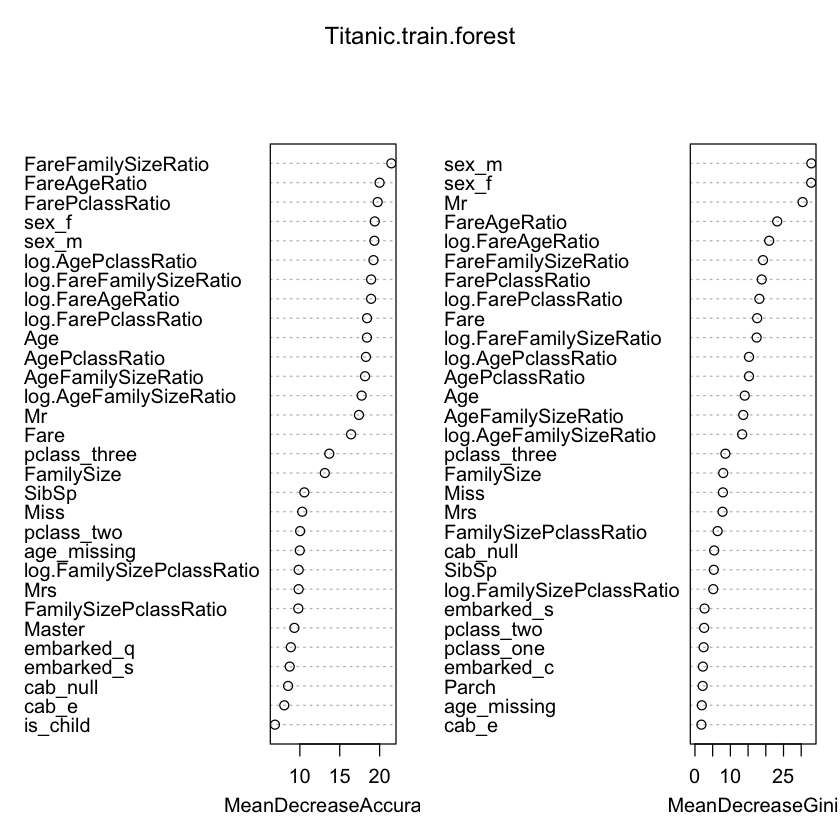

In [15]:
Titanic.train <- Titanic.combined[train.set.indices,]
Titanic.train$Survived <- Survived
Titanic.train.forest <- randomForest(Survived ~ ., data = Titanic.train[, features], importance=TRUE)
varImpPlot(Titanic.train.forest)

## Plot newly introduced features across "survived" labels.


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


Warning message:
“Removed 22 rows containing non-finite values (stat_boxplot).”


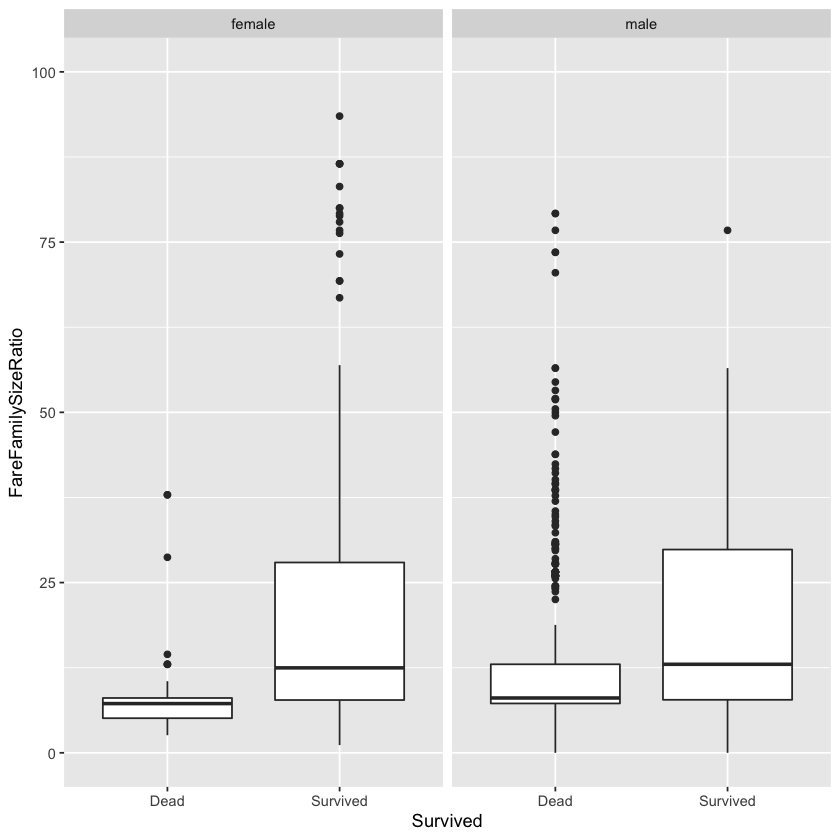

Warning message:
“Removed 9 rows containing non-finite values (stat_boxplot).”


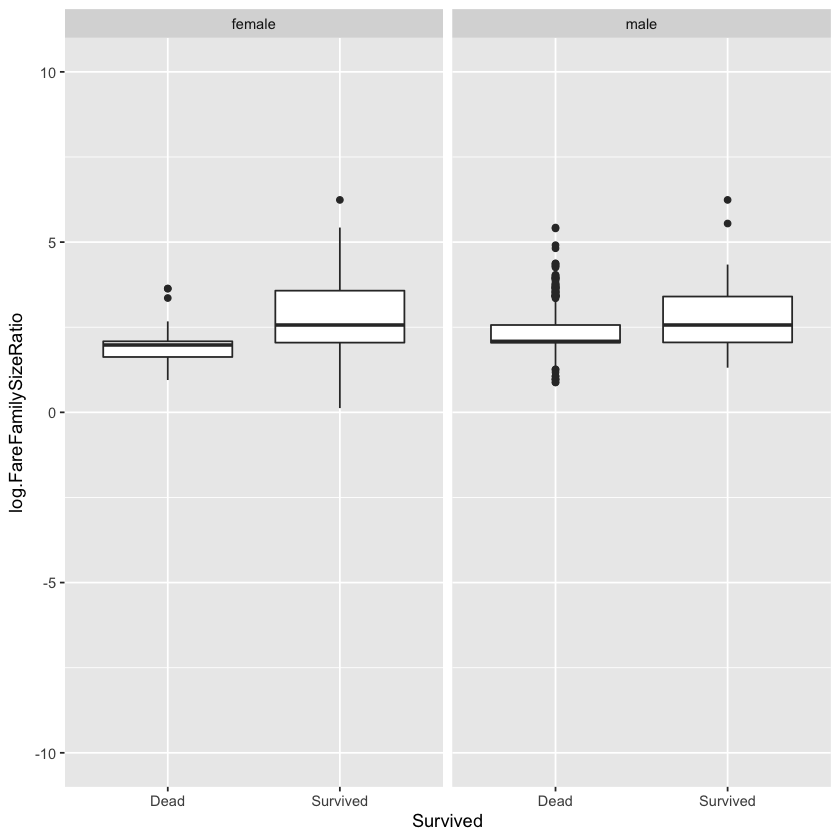

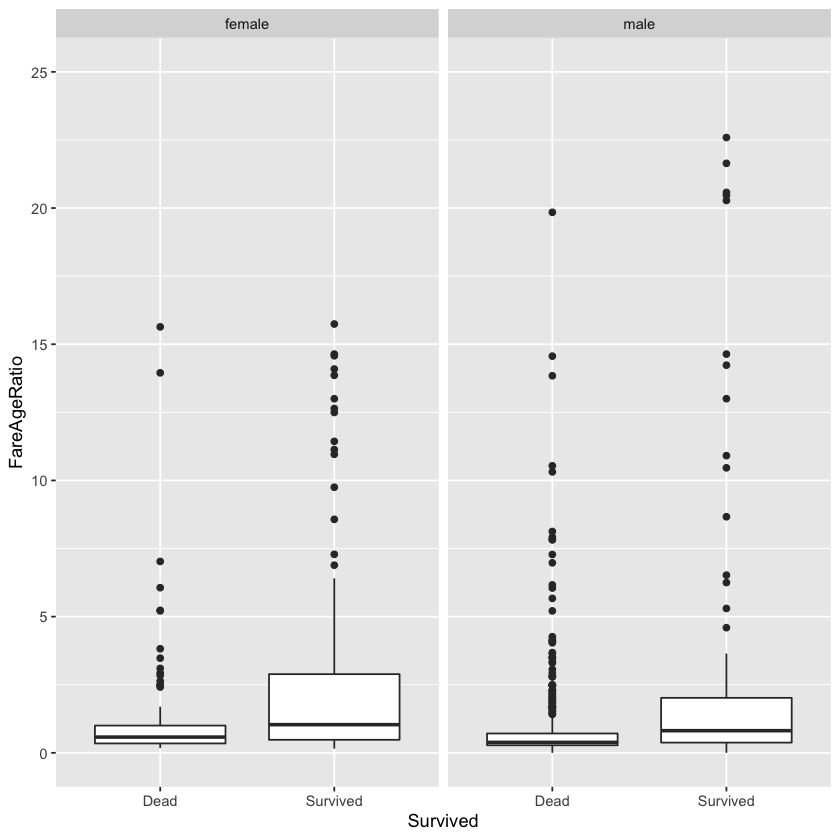

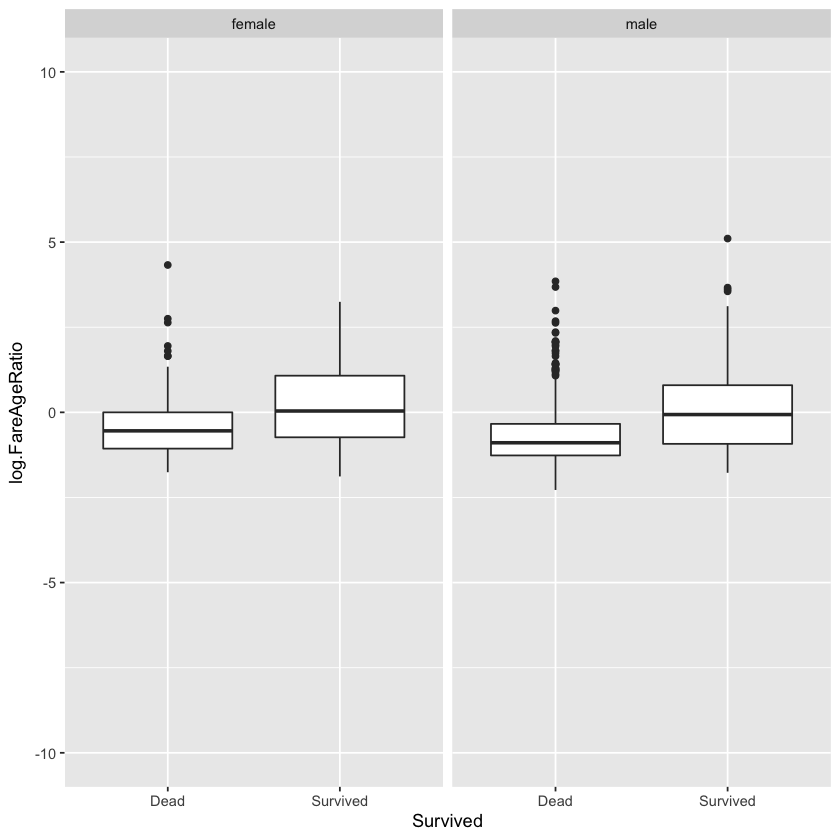

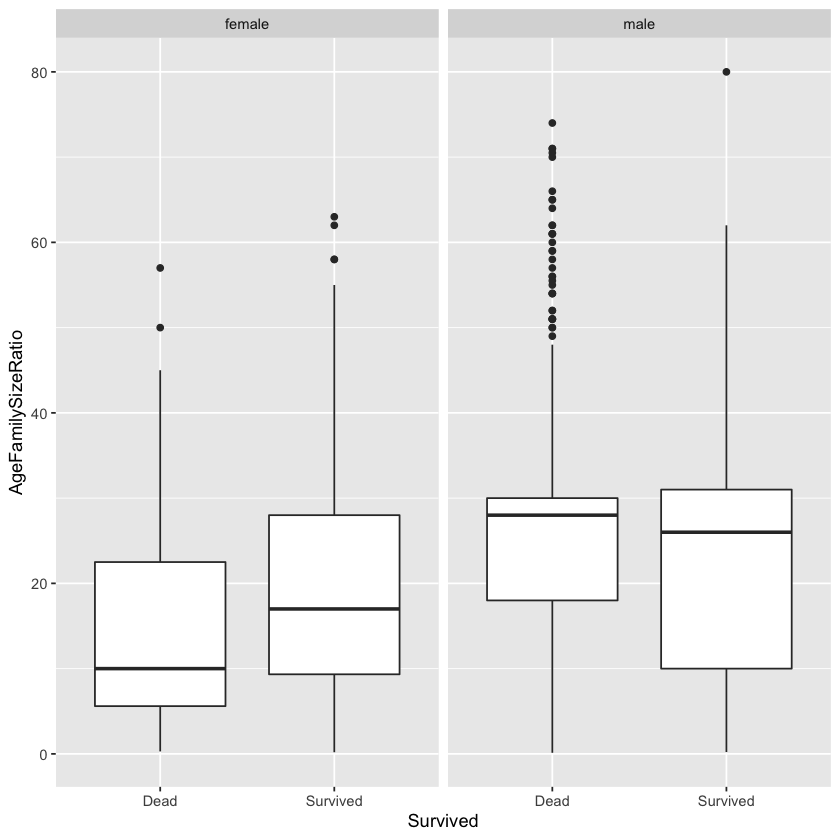

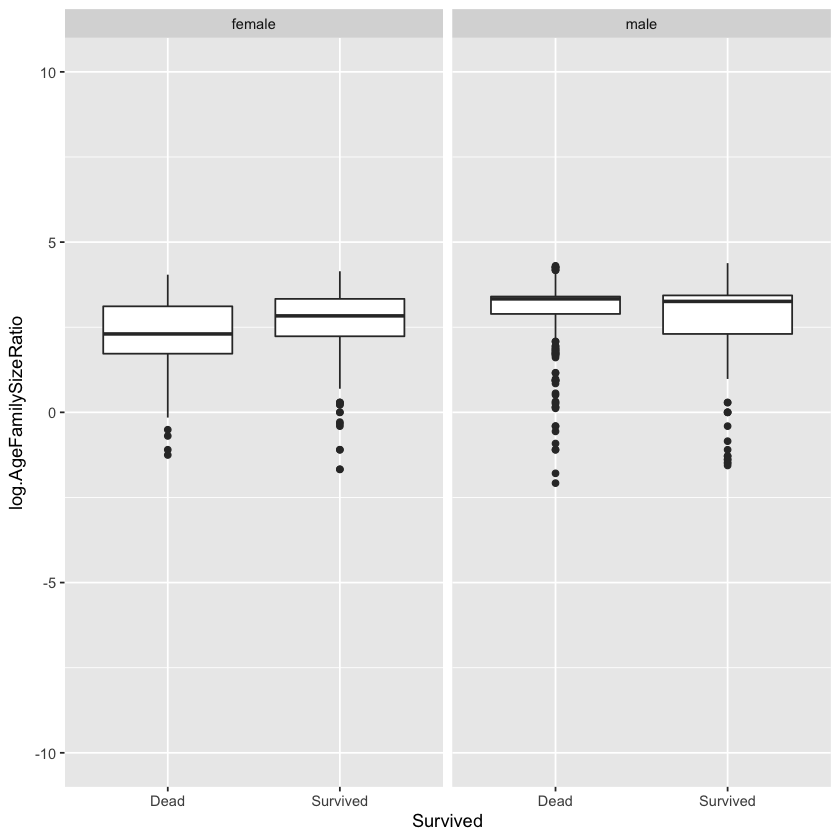

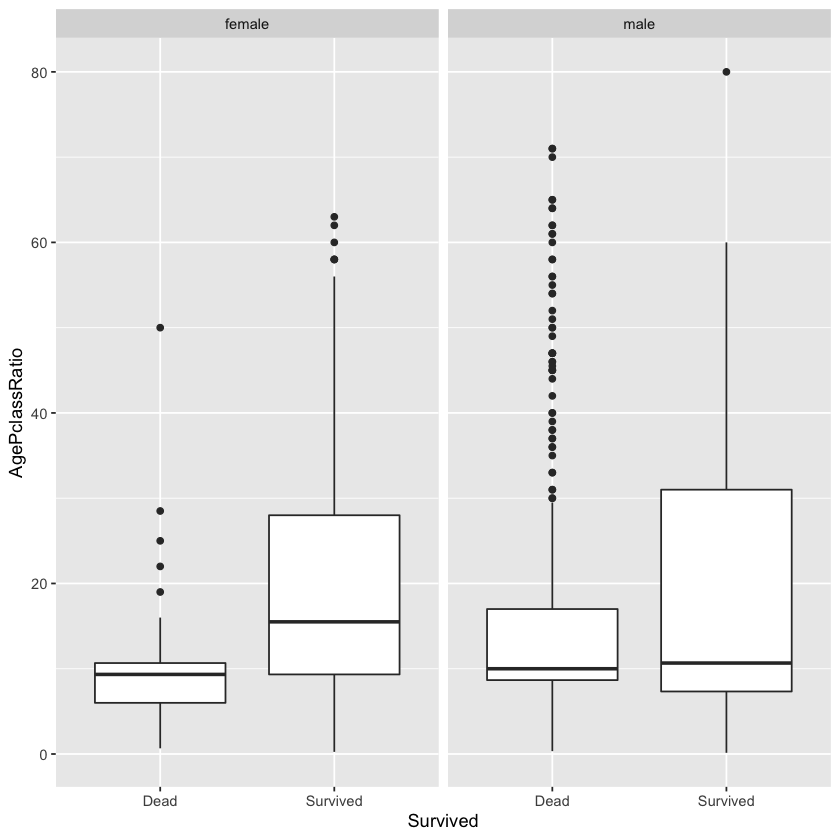

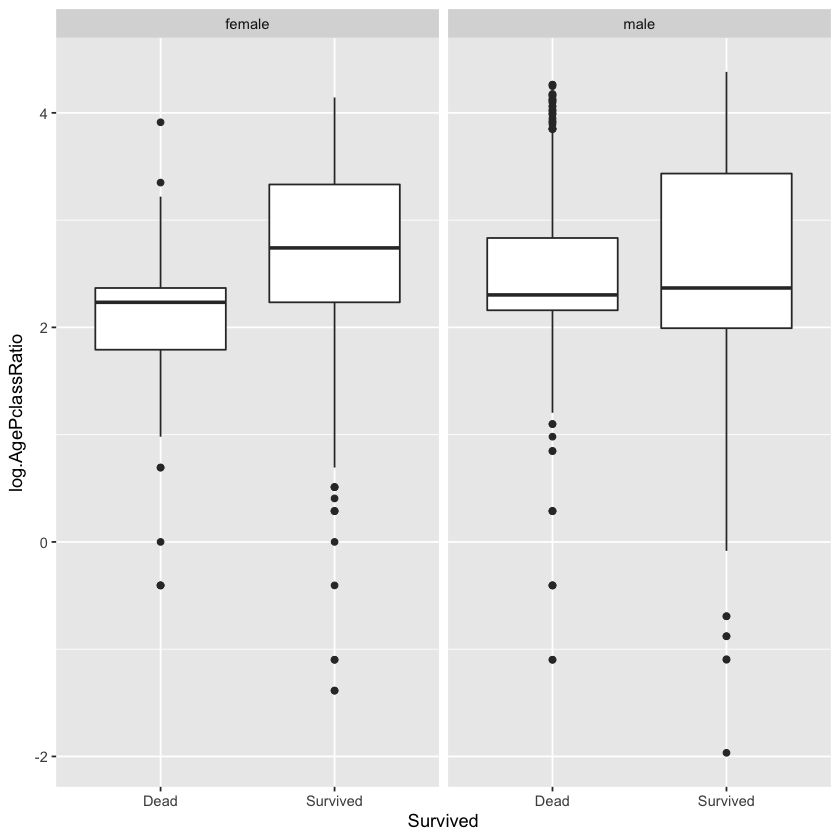

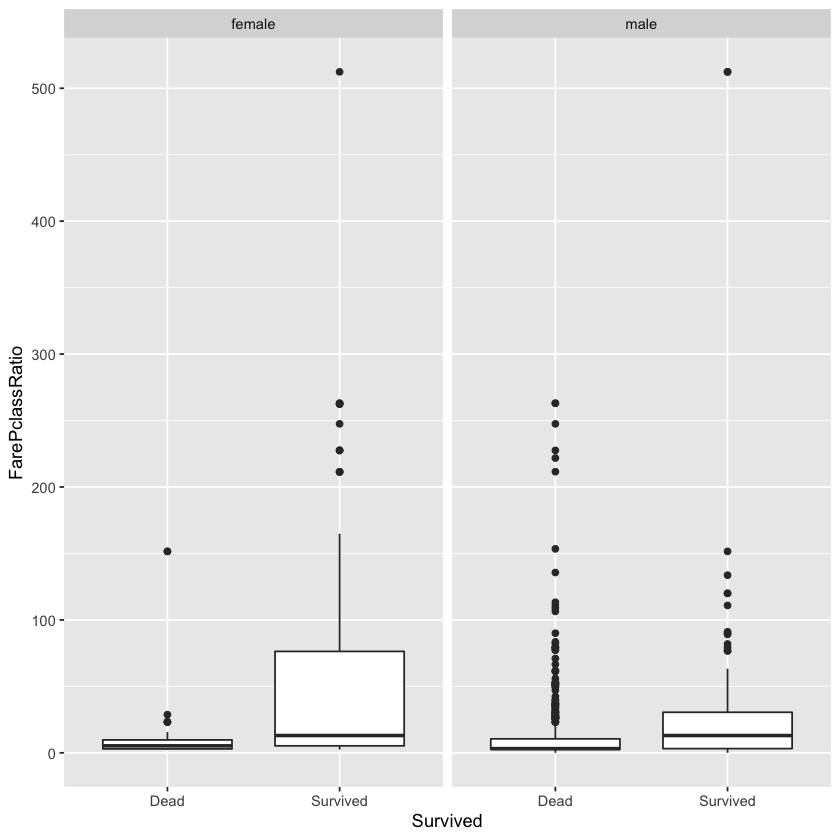

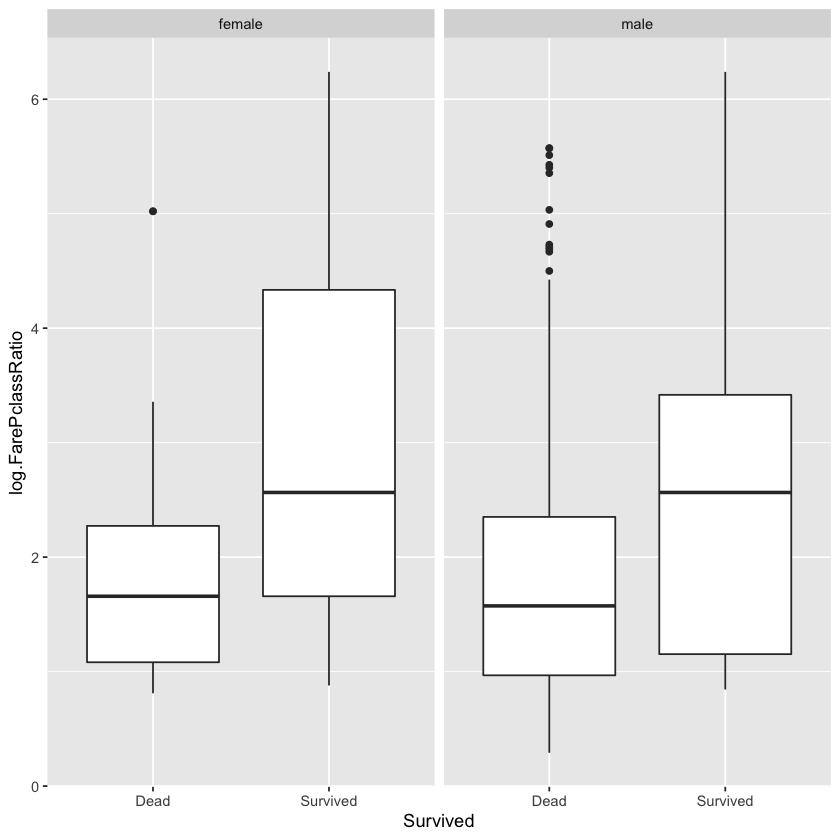

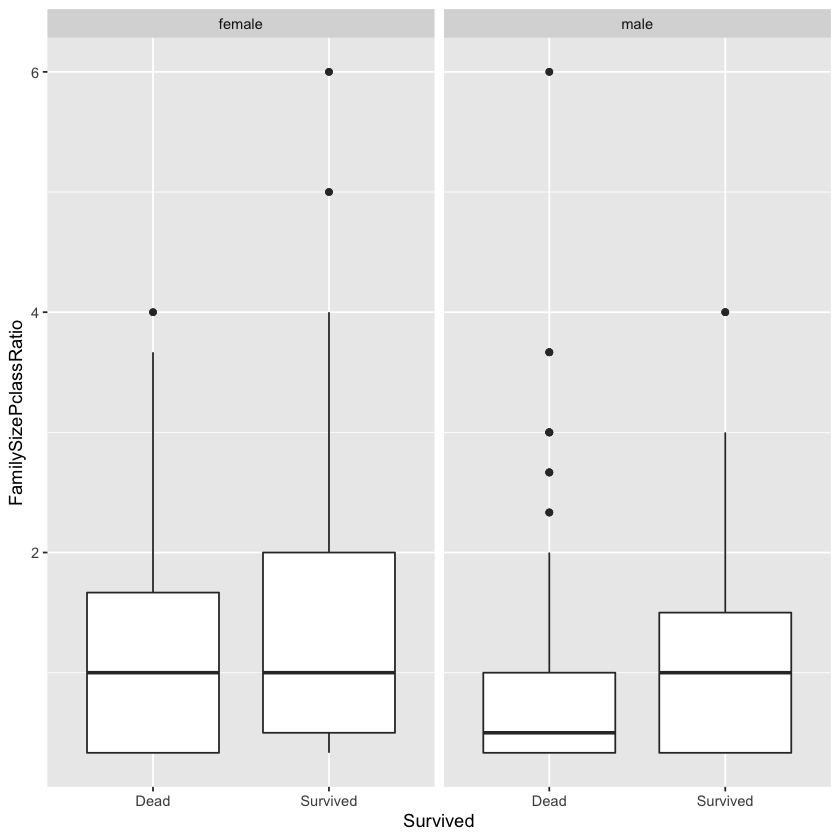

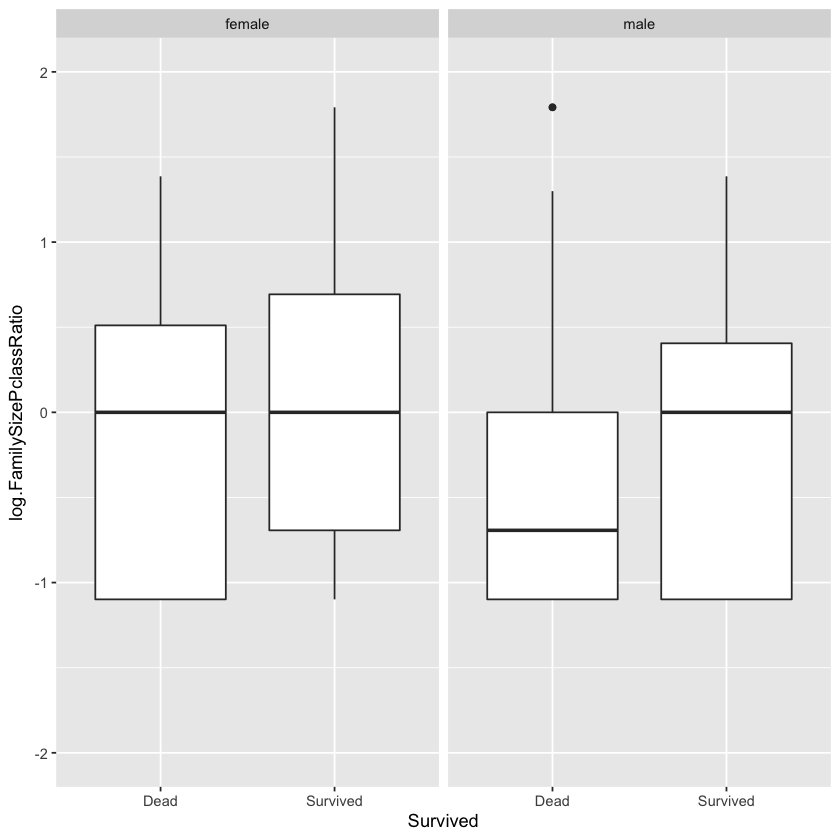

In [16]:
# NOTE: Please ignore the warning message
library(ggplot2)
FareFamilySizeRatio.boxplot <- ggplot(Titanic.train, aes(x=Survived, y=FareFamilySizeRatio))
FareFamilySizeRatio.boxplot + geom_boxplot() + facet_wrap(~ Sex) + ylim(0, 100)

log.FareFamilySizeRatio.boxplot <- ggplot(Titanic.train, aes(x=Survived, y=log.FareFamilySizeRatio))
log.FareFamilySizeRatio.boxplot + geom_boxplot() + facet_wrap(~ Sex) + ylim(-10, 10)

FareAgeRatio.boxplot <- ggplot(Titanic.train, aes(x=Survived, y=FareAgeRatio))
FareAgeRatio.boxplot + geom_boxplot() + facet_wrap(~ Sex) + ylim(0, 25)

log.FareAgeRatio.boxplot <- ggplot(Titanic.train, aes(x=Survived, y=log.FareAgeRatio))
log.FareAgeRatio.boxplot + geom_boxplot() + facet_wrap(~ Sex) + ylim(-10, 10)

AgeFamilySizeRatio.boxplot <- ggplot(Titanic.train, aes(x=Survived, y=AgeFamilySizeRatio))
AgeFamilySizeRatio.boxplot + geom_boxplot() + facet_wrap(~ Sex)

log.AgeFamilySizeRatio.boxplot <- ggplot(Titanic.train, aes(x=Survived, y=log.AgeFamilySizeRatio))
log.AgeFamilySizeRatio.boxplot + geom_boxplot() + facet_wrap(~ Sex) + ylim(-10, 10)

AgePclassRatio.boxplot <- ggplot(Titanic.train, aes(x=Survived, y=AgePclassRatio))
AgePclassRatio.boxplot + geom_boxplot() + facet_wrap(~ Sex)

log.AgePclassRatio.boxplot <- ggplot(Titanic.train, aes(x=Survived, y=log.AgePclassRatio))
log.AgePclassRatio.boxplot + geom_boxplot() + facet_wrap(~ Sex)

FarePclassRatio.boxplot <- ggplot(Titanic.train, aes(x=Survived, y=FarePclassRatio))
FarePclassRatio.boxplot + geom_boxplot() + facet_wrap(~ Sex)

log.FarePclassRatio.boxplot <- ggplot(Titanic.train, aes(x=Survived, y=log.FarePclassRatio))
log.FarePclassRatio.boxplot + geom_boxplot() + facet_wrap(~ Sex)

FamilySizePclassRatio.boxplot <- ggplot(Titanic.train, aes(x=Survived, y=FamilySizePclassRatio))
FamilySizePclassRatio.boxplot + geom_boxplot() + facet_wrap(~ Sex)

log.FamilySizePclassRatio.boxplot <- ggplot(Titanic.train, aes(x=Survived, y=log.FamilySizePclassRatio))
log.FamilySizePclassRatio.boxplot + geom_boxplot() + facet_wrap(~ Sex) + ylim(-2, 2)

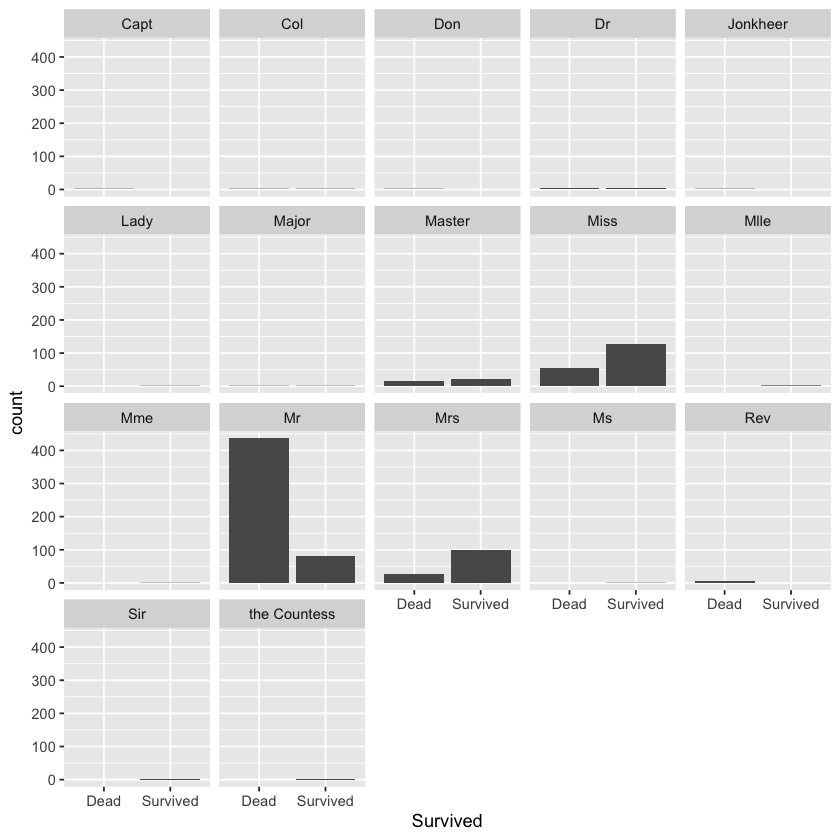

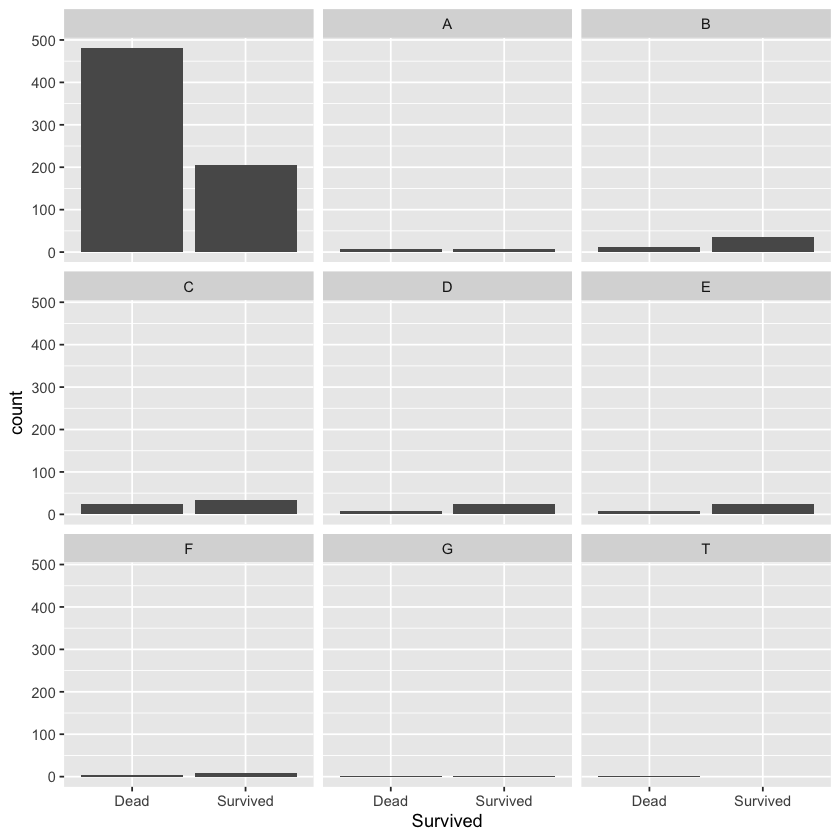

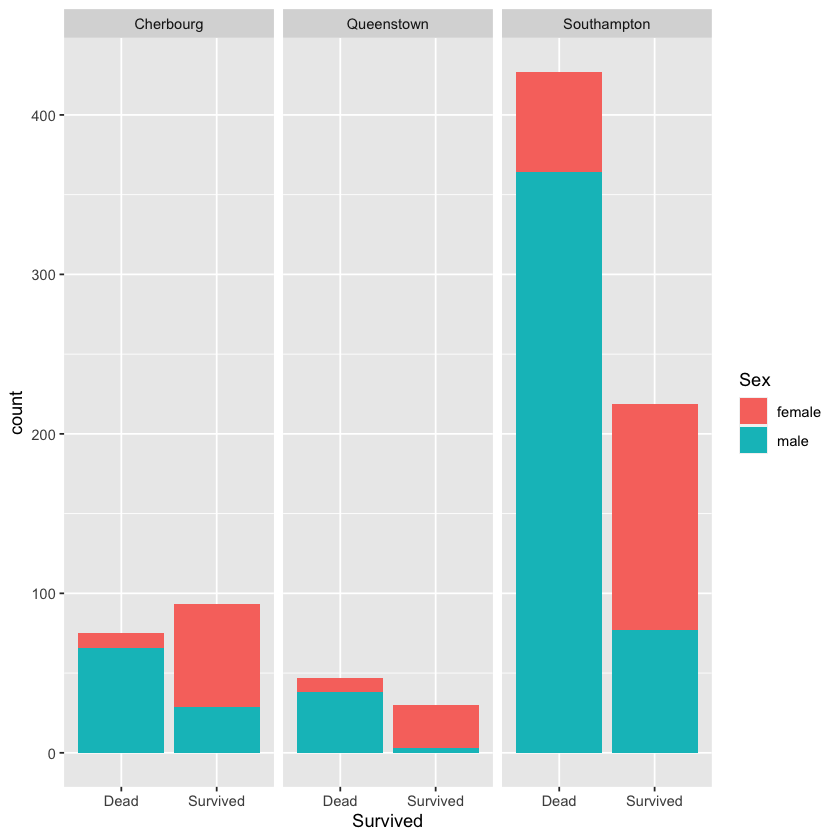

In [17]:
Title.barplot <- ggplot(Titanic.train, aes(x=Survived))
Title.barplot + geom_bar() + facet_wrap(~ Title)

CabinType.barplot <- ggplot(Titanic.train, aes(x=Survived))
CabinType.barplot + geom_bar() + facet_wrap(~ CabinType)

Embarked.barplot <- ggplot(Titanic.train, aes(x=Survived, fill=Sex))
Embarked.barplot + geom_bar() + facet_wrap(~ Embarked)

## Use k-means to cluster passengers by similarity of their features

Here we will normalize each of the feature vectors, after they have been enumerated (if necessary) so that they may be grouped by similarity via the k-means clustering algorithm.  A new feature vector that categorizes each record by its cluster assignment will then be added to the `Titanic.combined` data.frame for potential use in models that follow.

In [ ]:
features

In [27]:
# Load the required library
# NOTE: Please ignore the warning message.
library(caret)

clustering.features <- c("Pclass", "Sex", "Age", "SibSp", "Parch", 
            "Fare", "Embarked", "FamilySize", "AgeMissing",
            "FareAgeRatio", "log.FareAgeRatio",
            "AgeFamilySizeRatio", "log.AgeFamilySizeRatio",
            "FareFamilySizeRatio", "log.FareFamilySizeRatio",
            "AgePclassRatio", "log.AgePclassRatio",
            "FarePclassRatio", "log.FarePclassRatio", 
            "FamilySizePclassRatio", "log.FamilySizePclassRatio",
            "Mr", "Miss", "Mrs", "Master", "Rev",
            "HasFamily", "IsChild", "IsSenior")

#training.set <- Titanic.combined
#clustering.features <- colnames(training.set)
#clustering.features[!clustering.features %in% c("Survived", "Embarked", "CabinType", "Titles")]

dummy.vars <- dummyVars(~ ., Titanic.combined[, clustering.features])
titanic.dummy <- predict(dummy.vars, Titanic.combined[, clustering.features])
head(titanic.dummy)

,Pclass.1,Pclass.2,Pclass.3,Sex.female,Sex.male,Age,SibSp,Parch,Fare,Embarked.Cherbourg,⋯,Miss,Mrs,Master,Rev,HasFamily.FALSE,HasFamily.TRUE,IsChild.FALSE,IsChild.TRUE,IsSenior.FALSE,IsSenior.TRUE
1,0,0,1,0,1,22,1,0,7.2500,0,⋯,0,0,0,0,0,1,1,0,1,0
2,1,0,0,1,0,38,1,0,71.2833,1,⋯,0,1,0,0,0,1,1,0,1,0
3,0,0,1,1,0,26,0,0,7.9250,0,⋯,1,0,0,0,1,0,1,0,1,0
4,1,0,0,1,0,35,1,0,53.1000,0,⋯,0,1,0,0,0,1,1,0,1,0
5,0,0,1,0,1,35,0,0,8.0500,0,⋯,0,0,0,0,1,0,1,0,1,0
6,0,0,1,0,1,28,0,0,8.4583,0,⋯,0,0,0,0,1,0,1,0,1,0


In [28]:
# Each of the features have values that span different numerical ranges.  Here we will center 
# and scale (normalize) each of the features for k-means.
#titanic.dummy <- scale(titanic.dummy)
titanic.dummy <- scale(titanic.dummy)
head(titanic.dummy)

,Pclass.1,Pclass.2,Pclass.3,Sex.female,Sex.male,Age,SibSp,Parch,Fare,Embarked.Cherbourg,⋯,Miss,Mrs,Master,Rev,HasFamily.FALSE,HasFamily.TRUE,IsChild.FALSE,IsChild.TRUE,IsSenior.FALSE,IsSenior.TRUE
1,-0.5721328,-0.5178859,0.9195737,-0.7432129,0.7432129,-0.5814061,0.4811039,-0.4448295,-0.5028313,-0.5095751,⋯,-0.4976603,-0.4207409,-0.2209997,-0.07838634,-1.2332863,1.2332863,0.2780416,-0.2780416,0.3027755,-0.3027755
2,1.7465107,-0.5178859,-1.0866296,1.3444816,-1.3444816,0.6584003,0.4811039,-0.4448295,0.7345974,1.9609203,⋯,-0.4976603,2.3749438,-0.2209997,-0.07838634,-1.2332863,1.2332863,0.2780416,-0.2780416,0.3027755,-0.3027755
3,-0.5721328,-0.5178859,0.9195737,1.3444816,-1.3444816,-0.2714545,-0.4789037,-0.4448295,-0.4897871,-0.5095751,⋯,2.0078678,-0.4207409,-0.2209997,-0.07838634,0.8102223,-0.8102223,0.2780416,-0.2780416,0.3027755,-0.3027755
4,1.7465107,-0.5178859,-1.0866296,1.3444816,-1.3444816,0.4259366,0.4811039,-0.4448295,0.3832093,-0.5095751,⋯,-0.4976603,2.3749438,-0.2209997,-0.07838634,-1.2332863,1.2332863,0.2780416,-0.2780416,0.3027755,-0.3027755
5,-0.5721328,-0.5178859,0.9195737,-0.7432129,0.7432129,0.4259366,-0.4789037,-0.4448295,-0.4873715,-0.5095751,⋯,-0.4976603,-0.4207409,-0.2209997,-0.07838634,0.8102223,-0.8102223,0.2780416,-0.2780416,0.3027755,-0.3027755
6,-0.5721328,-0.5178859,0.9195737,-0.7432129,0.7432129,-0.1164787,-0.4789037,-0.4448295,-0.4794812,-0.5095751,⋯,-0.4976603,-0.4207409,-0.2209997,-0.07838634,0.8102223,-0.8102223,0.2780416,-0.2780416,0.3027755,-0.3027755


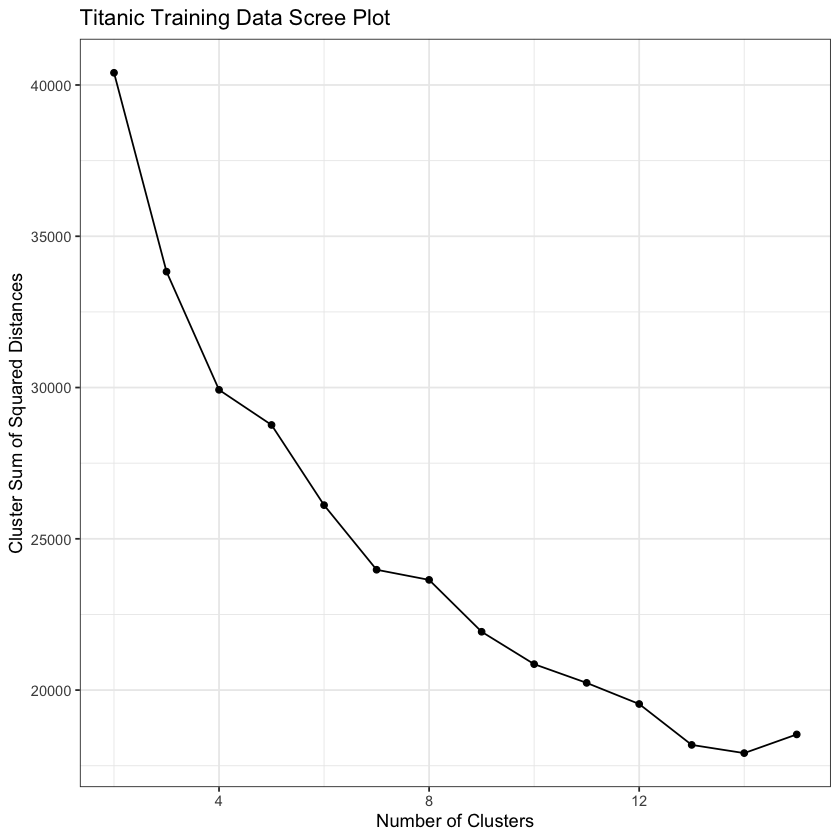

In [31]:
# Vary number k of clusters to use from 2 to 15, and repeat k-means clustering for each
# value of k.  Store total sum-of-squared distances across k clusters on each iteration.  Use
# Examine resultant vector for kink (elbow) in progressive decline in error.
max.k <- 15
clusters.sum.squares <- rep(0.0, max.k - 1)
cluster.params <- 2:max.k

for (i in cluster.params) {
    # Cluster data using k-means with the current value of i.
    kmeans.temp <- kmeans(titanic.dummy, centers = i)
    
    # Get the total sum of squared distances for all points
    # in the cluster and store it for plotting later.
    clusters.sum.squares[i - 1] <- sum(kmeans.temp$withinss)
}

# build the scree plot
# Load the required library
library(ggplot2)
# Plot our scree plot using the mighty ggplot2.
ggplot(NULL, aes(x=cluster.params, y=clusters.sum.squares)) +
  theme_bw() +
  geom_point() +
  geom_line() +
  labs(x="Number of Clusters",
       y="Cluster Sum of Squared Distances",
       title="Titanic Training Data Scree Plot")

In [37]:
# Cluster the data using the k value determined by the location of elbow in plot above.
# Add cluster assignments to the combined (train + test) data.frame.
num.clusters <- 4
titanic.kmeans <- kmeans(titanic.dummy, centers = num.clusters)
Titanic.combined$Cluster <- as.factor(titanic.kmeans$cluster)

In [38]:
# Now separate the .train and .test sets
Titanic.train <- Titanic.combined[train.set.indices,]
Titanic.test <- Titanic.combined[test.set.indices,]

# Insert Survived factor back into the .train dataset
Titanic.train <- Titanic.combined[train.set.indices,]
Survived <- as.factor(Survived)
levels(Survived)<-c("Dead", "Survived")
Titanic.train$Survived <- Survived

#head(Titanic.train, addrownums = TRUE)
#head(Titanic.test)
#row.names(Titanic.train)

In [39]:
head(Survived)

[1] Dead     Survived Survived Survived Dead     Dead    
Levels: Dead Survived

In [40]:
head(Titanic.train$Survived)

[1] Dead     Survived Survived Survived Dead     Dead    
Levels: Dead Survived

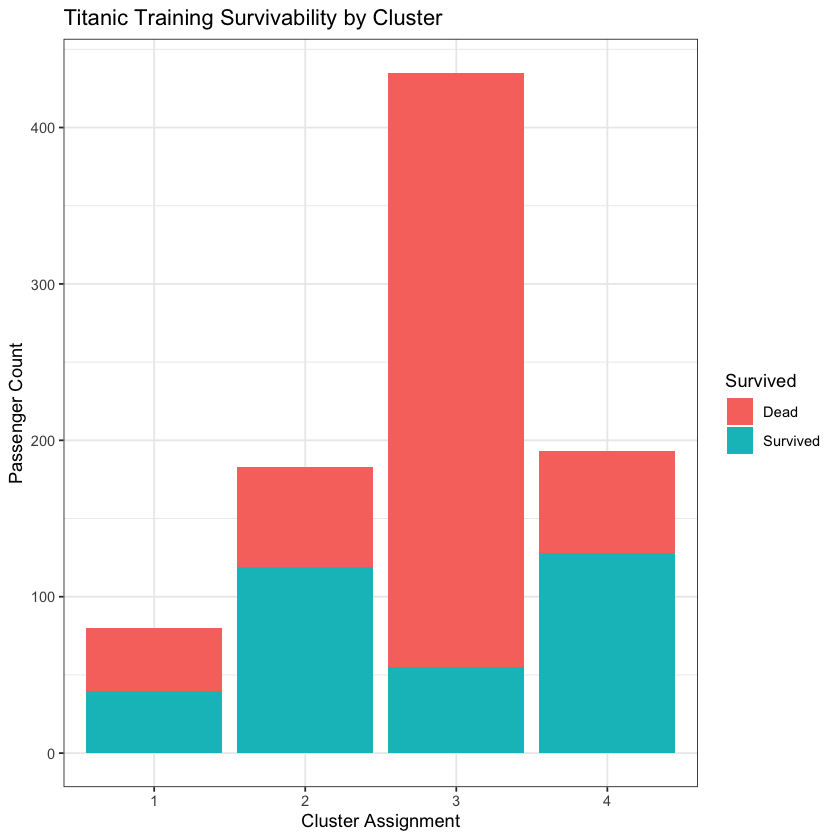

In [41]:
# Visualize survivability by cluster assignment.
ggplot(Titanic.train, aes(x=Cluster, fill=Survived)) +
  theme_bw() +
  geom_bar() +
  labs(x="Cluster Assignment",
       y="Passenger Count",
       title="Titanic Training Survivability by Cluster")

In [42]:
ranking.features <- c("Pclass", "Sex", "Age", "SibSp", "Parch",
                      "FareAgeRatio", "log.FareAgeRatio",
                      "AgeFamilySizeRatio", "log.AgeFamilySizeRatio",
                      "FareFamilySizeRatio", "log.FareFamilySizeRatio",
                      "AgePclassRatio", "log.AgePclassRatio",
                      "FarePclassRatio", "log.FarePclassRatio", 
                      "FamilySizePclassRatio", "log.FamilySizePclassRatio",
                      "Fare", "Embarked", "FamilySize", "AgeMissing",
                      "HasFamily", "IsChild", "IsSenior", "CabinType",
                      "Cluster", "Title")
dummy.vars <- dummyVars(~ ., Titanic.train[, ranking.features])
Titanic.train.dummy <- predict(dummy.vars, Titanic.train[, ranking.features])
colnames(Titanic.train.dummy)[colnames(Titanic.train.dummy) == "Title.the Countess"] <- "Title.the_Countess"
#Titanic.train.dummy[,"Title.the_Countess"]

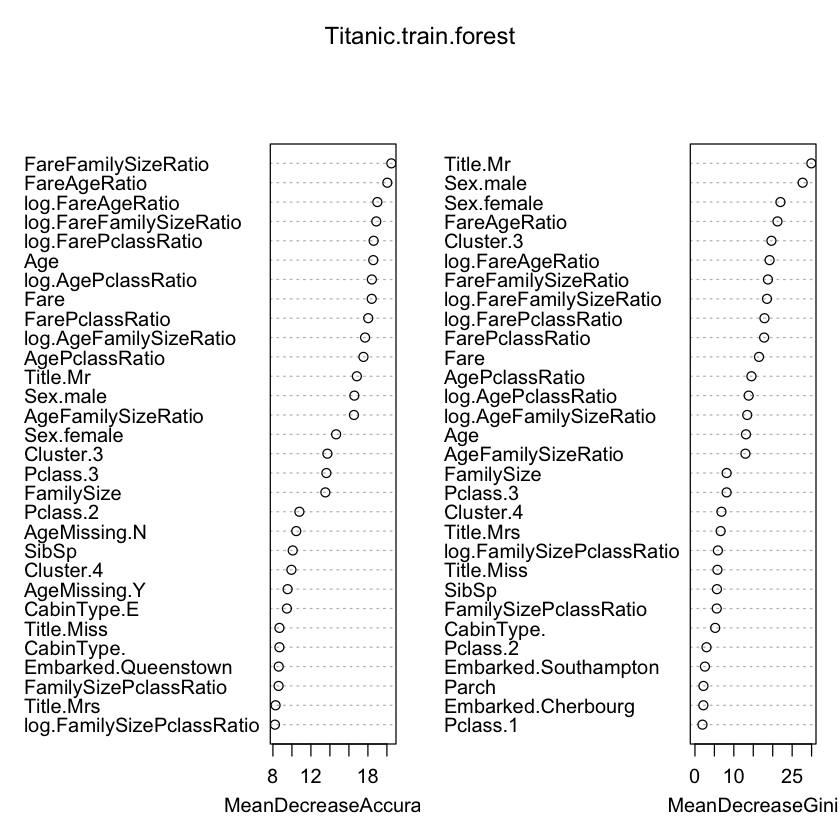

In [43]:
Titanic.train.forest <- randomForest(Survived ~ ., data = Titanic.train.dummy, importance=TRUE)
varImpPlot(Titanic.train.forest)

In [44]:
# Examine summary statistics of the training data.
class(Titanic.train)
summary(Survived)

[1] "data.frame"

Dead Survived 
     549      342

### Build a Single Decision Tree Model
Begin by randomly sampling training and testing subsets from this total training dataset.  We will use this to appraise the accuracy of the approach prior to incorporating the entire set of training data to build the decision tree.

In [45]:
subtrain.index <- sample(1:nrow(Titanic.train), 0.7*nrow(Titanic.train), replace = FALSE)
Titanic.subtrain <- Titanic.train[subtrain.index, ]
Titanic.subtest <- Titanic.train[-subtrain.index, ]
str(Titanic.subtrain)
str(Titanic.subtest)

'data.frame':	623 obs. of  70 variables:
 $ PassengerId              : int  300 303 20 854 112 298 502 795 191 429 ...
 $ Pclass                   : Factor w/ 3 levels "1","2","3": 1 3 3 1 3 1 3 3 2 3 ...
 $ Name                     : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 72 416 517 490 889 18 134 202 669 254 ...
 $ Sex                      : Factor w/ 2 levels "female","male": 1 2 1 1 1 1 1 2 1 2 ...
 $ Age                      : num  50 19 28 16 14.5 2 21 25 32 28 ...
 $ SibSp                    : int  0 0 0 0 1 1 0 0 0 0 ...
 $ Parch                    : int  1 0 0 1 0 2 0 0 0 0 ...
 $ Ticket                   : Factor w/ 929 levels "110152","110413",..: 586 575 185 592 194 38 434 351 123 438 ...
 $ Fare                     : num  247.52 0 7.22 39.4 14.45 ...
 $ Cabin                    : Factor w/ 187 levels "","A10","A14",..: 38 1 1 101 1 64 1 1 1 1 ...
 $ Embarked                 : Factor w/ 3 levels "Cherbourg","Queenstown",..: 1 3 1 3 1 3 2 3 3 2 ...
 $ AgeMissing    

In [96]:
# Compute decision tree
model_spec <- c('Survived', 'Sex', 'Pclass', 'Age', 'Fare', 'Embarked',
                'Mr', 'Miss', 'Master', 'Mrs', 'Rev',
                "FareAgeRatio", "log.FareAgeRatio",
                "AgeFamilySizeRatio", "log.AgeFamilySizeRatio",
                "FareFamilySizeRatio", "log.FareFamilySizeRatio",
                "AgePclassRatio", "log.AgePclassRatio",
                "FarePclassRatio", "log.FarePclassRatio", 
                "FamilySizePclassRatio", "log.FamilySizePclassRatio",
                'FamilySize', 'CabinType', 'Cluster')

train_control <- rpart.control()
parms_control <- list(split="gini")

titanic.tree <- rpart(Survived ~ ., 
                        data = Titanic.subtrain[model_spec], 
                        method="class", parms=parms_control,
                        control = train_control, model=TRUE)

In [ ]:
as.formula(titanic.tree)

In [ ]:
titanic.tree
as.formula(titanic.tree)

In [ ]:
# Visualize the model
# Plot the tree structure
library(rpart.plot)
rpart.plot(titanic.tree)
title(main = "Decision Tree Model of Titanic Data")
text(titanic.tree, use.n = TRUE)

In [ ]:
# Predict survival of passengers in the the Titanic.subtest dataset using the decision model
Titanic.subtest.predictions <- predict(titanic.tree, Titanic.subtest, type="class")
head(Titanic.subtest.predictions)

In [ ]:
# Predicted values can also be probabilities,instead of class labels
Titanic.subtest.predictions.prob <- predict(titanic.tree, Titanic.subtest, type = "prob")
head(Titanic.subtest.predictions.prob)

In [ ]:
# Comparison table of actual values and predicted values
Titanic.comparison <- Titanic.subtest
Titanic.comparison$Predictions <- Titanic.subtest.predictions
head(Titanic.comparison[ , c("Survived", "Predictions")])

In [ ]:
# View misclassified rows
disagreement.index <- Titanic.comparison$Survived != Titanic.comparison$Predictions 
head(Titanic.comparison[disagreement.index, ])
sum(disagreement.index)

In [ ]:
# Build the confusion matrix
titanic.dt.confusion <- table(Titanic.comparison$Predictions, Titanic.subtest[,"Survived"])
print(titanic.dt.confusion)

In [ ]:
# Accuracy
titanic.dt.accuracy <- sum(diag(titanic.dt.confusion)) / sum(titanic.dt.confusion)
cat("Accuracy: ", titanic.dt.accuracy)
# Precision
titanic.dt.precision <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[2,])
cat("\nPrecision: ", titanic.dt.precision)
# Recall
titanic.dt.recall <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[,2])
cat("\nRecall: ", titanic.dt.recall)
# F1 score
titanic.dt.F1 <- 2 * titanic.dt.precision * titanic.dt.recall / (titanic.dt.precision + titanic.dt.recall)
cat("\nF1-score: ", titanic.dt.F1)

### Perform Grid Search to Determine Optimal Hyperparameters

Generate the grid of all possible hyperparameter combinations on which to perform search.

In [ ]:
# Grid search across all possible hyperparameters
tune.grid <- expand.grid(maxdepth=2:6, minsplit=2:6, minbucket=2:10, accuracy=0.00)
#tune.grid

Iterate over all rows of the grid table generated above, calculating model accuracy for each iteration.

In [ ]:
for(i in 1:nrow(tune.grid)){
  titanic.tree.3 <- rpart(as.formula(titanic.tree), data=Titanic.train, 
                         control=rpart.control(maxdepth=tune.grid[i,1], 
                                               minsplit=tune.grid[i,2], 
                                               minbucket=tune.grid[i,3]))
  titanic.predictions <- predict(titanic.tree.3, Titanic.subtest, type="class")
  titanic.confusion <- table(titanic.predictions, Titanic.subtest$Survived)
  titanic.accuracy <- sum(diag(titanic.confusion)) / sum(titanic.confusion)
  tune.grid[i,4] <- titanic.accuracy
    }

#tune.grid
# Select the tuned model with highest accuracy
best.tuned.params <- tune.grid[which.max(tune.grid$accuracy),]
best.tuned.params

# Insert optimized hyperparameters into rpart.control function definition
train_control.best <- rpart.control(maxdepth=best.tuned.params[1], 
                                    minsplit=best.tuned.params[2], 
                                    minbucket=best.tuned.params[3])

## Perform k-fold Cross-Validation on Single Decision Tree

In [ ]:
# Load the required package
library(caret)
# Set up caret to perform 10-fold cross validation repeated 3 times
caret.control <- trainControl(method = "repeatedcv",
                              number = 10,
                              repeats = 3)

In [ ]:
library(e1071)
# Use caret to train the rpart decision tree using 10-fold cross 
# validation repeated 3 times and use 15 values for tuning the
# cp parameter for rpart. This code returns the best model trained
# on all the data! Mighty!

model_to_eval <- titanic.tree.3
#model_to_eval <- Titanic.rf.model
rpart.cv <- train(as.formula(model_to_eval), data=Titanic.train, 
                  method = "rpart",
                  control = train_control.best,
                  trControl = caret.control,
                  tuneLength = 15)

In [ ]:
# Display the results of the cross validation run
rpart.cv

In [ ]:
# What is the standard deviation?
cat(paste("\nCross validation standard deviation:",  
          sd(rpart.cv$resample$Accuracy), "\n", sep = " "))

In [ ]:
# Pull out the the trained model using the best parameters on
# all the data! Mighty!
rpart.best <- rpart.cv$finalModel

In [ ]:
# Look at the model - this model is trained on 100% of the data!
rpart.best

In [ ]:
# Load the required package
library(rpart.plot)
# Make the model look pretty
prp(rpart.best, type = 0, extra = 1, under = TRUE)

### Make Predictions on Test Set

In [ ]:
# Produce predictions using complete decision tree
Titanic.test.predictions <- predict(rpart.cv, Titanic.test, type = "raw")
head(Titanic.test.predictions)

# Predicted values can also be probabilities,instead of class labels
Titanic.test.predictions.prob <- predict(rpart.cv, Titanic.test, type = "prob")
head(Titanic.test.predictions.prob)

In [ ]:
str(Titanic.test)

In [ ]:
Survived<-as.numeric(Titanic.test.predictions == "Survived")
PassengerId<-Titanic.test$PassengerId
out.df<-data.frame(PassengerId, Survived)

In [ ]:
head(out.df)

In [ ]:
write.csv(out.df, "Predictions/survival_predictions_dt##.csv", row.names=FALSE)

## Ensemble of Bagged Decision Trees Approach

In [ ]:
# Specifies number of trees to fit that will comprise forest
nTrees <- 75

# Dataset to train on
training.set <- Titanic.subtrain
nTrainingSamples <- nrow(training.set)
train.indices <- 1:nTrainingSamples

levels_list <- levels(training.set$Survived)

# Dataset to test on
testing.set <- Titanic.subtest
nTestingSamples <- nrow(testing.set)
#testing.set$Survived <- factor(sample(levels_list, nTestingSamples, replace = TRUE))

# Initialize loop arrays
TreeArray <- vector("list", length = nTrees)
TreePredictions <- vector("character", length = nTrees)

ForestPredictions <- vector("character", length = nTestingSamples)

# Fit trees to randomly-sampled (with replacement) subsets of training data
for (i in 1:nTrees){
    
    training.sample.indices <- sample(train.indices, nTrainingSamples, replace = TRUE)
    training.sample.set <- training.set[training.sample.indices,]
    
    TreeArray[[i]] <- rpart(as.formula(titanic.tree.3), data = training.sample.set,
                            method = "class", parms = parms_control,
                            control = train_control.best, model = TRUE)
}

In [ ]:
levels_list[which.max(table(predict(TreeArray[[11]], testing.set[2,], type="class")))]

In [ ]:
# For each element (row) of the test set dataframe, have all trees generate predictions for that
# instance and use the majority as the forest decision
for (j in 1:nTestingSamples){
    
    for (i in 1:nTrees){
        
        TreePredictions[i] <- levels_list[which.max(table(predict(TreeArray[[i]], testing.set[j,], type="class")))]
    }
    
    TreePredictions <- as.factor(TreePredictions)
    levels(TreePredictions) <- levels_list
    ForestPredictions[j] <- levels_list[which.max(table(TreePredictions))]
}

In [ ]:
# Comparison table of actual values and predicted values
Titanic.comparison <- testing.set
Titanic.comparison$Predictions <- as.factor(unlist(ForestPredictions))
titanic.dt.confusion <- table(Titanic.comparison[,c("Predictions","Survived")])

# Accuracy
titanic.dt.accuracy <- sum(diag(titanic.dt.confusion)) / sum(titanic.dt.confusion)
cat("Accuracy: ", titanic.dt.accuracy)
# Precision
titanic.dt.precision <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[2,])
cat("\nPrecision: ", titanic.dt.precision)
# Recall
titanic.dt.recall <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[,2])
cat("\nRecall: ", titanic.dt.recall)
# F1 score
titanic.dt.F1 <- 2 * titanic.dt.precision * titanic.dt.recall / (titanic.dt.precision + titanic.dt.recall)
cat("\nF1-score: ", titanic.dt.F1)

In [ ]:
table(as.factor(ForestPredictions))

In [ ]:
Survived<-as.numeric(ForestPredictions == "Survived")
PassengerId<-testing.set$PassengerId
out.df<-data.frame(PassengerId, Survived)
write.csv(out.df, "Predictions/survival_predictions_dt39.csv", row.names=FALSE)

## Random Forest approach

In [ ]:
# Specify features to include in random forest
feature_filter <- (!model_spec %in% c())
rf.model_spec <- append(model_spec[feature_filter], c())
model_spec
feature_filter
rf.model_spec

In [ ]:
# Load the required library
library(randomForest)

# Dataset to train on
training.set <- Titanic.train
nTrainingSamples <- nrow(training.set)
train.indices <- 1:nTrainingSamples

levels_list <- levels(training.set$Survived)

# Dataset to test on
testing.set <- Titanic.test
nTestingSamples <- nrow(testing.set)

# Specify number of trees to include in the forest
num.trees <- 125

# Fit a random forest model to the training set
titanic.rf.model <- randomForest(Survived ~ ., data=training.set[, rf.model_spec], 
                                 mtry=round(sqrt(length(rf.model_spec))),
                                 importance=TRUE, ntree=num.trees)

# The randomForest object
print(titanic.rf.model)

In [ ]:
# Conduct grid search for optimal hyper-parameters via repeated k-fold cross-validation.
rfGrid.cv <- expand.grid(
                mtry=2:(length(rf.model_spec)-1)
                )

tol.val <- 0.05
metric.rf <- "Accuracy"
maximize.rf <- TRUE
tolFunc.rf <- function(x, metric, maximize){
    tolerance(x, metric=metric, tol=tol.val, maximize=maximize)
}
fitControl.cv <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           ## repeated ten times
                           repeats = 5,
                           selectionFunction="tolFunc.rf")

titanic.rf.model.cv <- train(Survived ~ ., data=training.set[, rf.model_spec], method = "rf", 
                            ntree=num.trees, importance=TRUE, trControl=fitControl.cv, tuneGrid=rfGrid.cv,
                            metric=metric.rf, maximize=maximize.rf)

titanic.rf.model.cv

In [ ]:
trellis.par.set(caretTheme())
plot(titanic.rf.model.cv)
titanic.rf.model.cv$results

In [ ]:
titanic.rf.model.cv.best <- titanic.rf.model.cv$finalModel
titanic.rf.model.cv.best

In [ ]:
# Retrain final model using complete dataset.  [Not sure if this is done for $finalModel in caret object]
titanic.rf.model.final <- randomForest(Survived ~ ., data=training.set[, rf.model_spec], 
                                 mtry=titanic.rf.model.cv.best$mtry,
                                 importance=TRUE, ntree=num.trees)
titanic.rf.model.final

In [ ]:
# Make predictions using titanic.rf.model.cv$finalModel
titanic.rf.predictions <- predict(titanic.rf.model.cv, 
                                  newdata=testing.set, 
                                  type="raw")
head(titanic.rf.predictions)
length(titanic.rf.predictions)

In [ ]:
# NOTE: This cell works only if the model was trained with training.set <- Titanic.subtrain and 
# testing.set <- Titanic.subtest.  Will throw error if testing.set <- Titanic.test as there is no
# "Survived" feature in the dataframe.

# Build the confusion matrix
titanic.rf.confusion <- table(titanic.rf.predictions, testing.set$Survived)
print(titanic.rf.confusion)

# Accuracy
titanic.rf.accuracy <- sum(diag(titanic.rf.confusion)) / sum(titanic.rf.confusion)
cat("Accuracy: ", titanic.rf.accuracy)
# Precision
titanic.rf.precision <- titanic.rf.confusion[2,2] / sum(titanic.rf.confusion[2,])
cat("\nPrecision: ", titanic.rf.precision)
# Recall
titanic.rf.recall <- titanic.rf.confusion[2,2] / sum(titanic.rf.confusion[,2])
cat("\nRecall: ", titanic.rf.recall)
# F1 score
titanic.rf.F1 <- 2 * titanic.rf.precision * titanic.rf.recall / (titanic.rf.precision + titanic.rf.recall)
cat("\nF1-score: ", titanic.rf.F1)

In [ ]:
# Generate predictions list.
Survived<-as.numeric(titanic.rf.predictions == "Survived")
PassengerId<-testing.set$PassengerId
out.df<-data.frame(PassengerId, Survived)
write.csv(out.df, "Predictions/survival_predictions_dt40.csv", row.names=FALSE)

## Ensemble of Boosted Decision Trees Approach

In [ ]:
feature_filter <- (!model_spec %in% c('Age', 'Fare', 'CabinType', 'FareAgeRatio', 'AgeFamilySizeRatio', 'FareFamilySizeRatio'))
bdt.model_spec <- append(model_spec[feature_filter], c('Rev', 'cab_null', 'cab_b', 'cab_d', 'cab_e'))
model_spec
feature_filter
bdt.model_spec

In [ ]:
# Load the required library
# NOTE: Please ignore the warning message
library(caret)

# Dataset to train on
training.set <- Titanic.train
nTrainingSamples <- nrow(training.set)
train.indices <- 1:nTrainingSamples

levels_list <- levels(training.set$Survived)

# Dataset to test on
testing.set <- Titanic.test
nTestingSamples <- nrow(testing.set)

# Gradient boosting classification model
# Specify model type in control function
control <- trainControl(summaryFunction = twoClassSummary, classProbs=TRUE)

# Specify hyperparameters for conducting gradient boosting procedure
gbmgrid <- expand.grid(interaction.depth=4, n.trees = 25, shrinkage=0.1, n.minobsinnode=5)

titanic.gbm.model <- train(Survived ~ ., data=training.set[, bdt.model_spec], method = "gbm", 
                           metric="ROC", trControl = control, tuneGrid = gbmgrid)

In [ ]:
titanic.gbm.model$best

In [ ]:
# Conduct grid search for optimal hyper-parameters via repeated k-fold cross-validation.
gbmGrid.cv <- expand.grid(
                interaction.depth = seq(2,8,by=1),
                n.trees = (1:3)*25,
                shrinkage = 0.1,
                n.minobsinnode = seq(3,7,by=1))

tol.val <- 1
maximize.gbm <- TRUE
tolFunc <- function(x, metric, maximize){
    tolerance(x, metric=metric, tol=tol.val, maximize=maximize)
}

metric.gbm.1 <- "Accuracy"
fitControl.cv.1 <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           ## repeated ten times
                           repeats = 5,
                           selectionFunction = "tolFunc")

metric.gbm.2 <- "ROC"
fitControl.cv.2 <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           ## repeated ten times
                           repeats = 5,
                           selectionFunction = "tolFunc",
                           summaryFunction = twoClassSummary,
                           classProbs=TRUE)

titanic.gbm.model.cv <- train(Survived ~ ., data=training.set[, bdt.model_spec], method = "gbm", 
                              verbose=FALSE, trControl=fitControl.cv.1, tuneGrid=gbmGrid.cv, 
                              metric=metric.gbm.1, maximize=maximize.gbm)


In [ ]:
titanic.gbm.model.cv

In [ ]:
titanic.gbm.model.cv$best
as.numeric(rownames(titanic.gbm.model.cv$best))
titanic.gbm.model.cv$results[rownames(titanic.gbm.model.cv$best),]

In [ ]:
trellis.par.set(caretTheme())
plot(titanic.gbm.model.cv )

In [ ]:
# Make predictions using titanic.gbm.model.cv$finalModel
titanic.gbm.predictions <- predict(titanic.gbm.model.cv, 
                                  newdata=testing.set, 
                                  type="raw")
head(titanic.gbm.predictions)
length(titanic.gbm.predictions)

In [ ]:
# NOTE: This cell works only if the model was trained with training.set <- Titanic.subtrain and 
# testing.set <- Titanic.subtest.  Will throw error if testing.set <- Titanic.test as there is no
# "Survived" feature in the dataframe.

# Build the confusion matrix
titanic.gbm.confusion <- table(titanic.gbm.predictions, testing.set$Survived)
print(titanic.gbm.confusion)

# Accuracy
titanic.gbm.accuracy <- sum(diag(titanic.gbm.confusion)) / sum(titanic.gbm.confusion)
cat("Accuracy: ", titanic.gbm.accuracy)
# Precision
titanic.gbm.precision <- titanic.gbm.confusion[2,2] / sum(titanic.gbm.confusion[2,])
cat("\nPrecision: ", titanic.gbm.precision)
# Recall
titanic.gbm.recall <- titanic.gbm.confusion[2,2] / sum(titanic.gbm.confusion[,2])
cat("\nRecall: ", titanic.gbm.recall)
# F1 score
titanic.gbm.F1 <- 2 * titanic.gbm.precision * titanic.gbm.recall / (titanic.gbm.precision + titanic.gbm.recall)
cat("\nF1-score: ", titanic.gbm.F1)

In [ ]:
# Generate predictions list.
Survived<-as.numeric(titanic.gbm.predictions == "Survived")
PassengerId<-testing.set$PassengerId
out.df<-data.frame(PassengerId, Survived)
write.csv(out.df, "Predictions/survival_predictions_dt36.csv", row.names=FALSE)

### Perform Bootstrap of Model

In [ ]:
# Specify number of runs to repeat
nReps <- 100

# Initialize storage vectors
Accuracy.Vec <- vector("numeric", length=nReps)
Precision.Vec <- vector("numeric", length=nReps)
Recall.Vec <- vector("numeric", length=nReps)
F1_score.Vec <- vector("numeric", length=nReps)

# Repeat decsion tree generation and performance evaluation nReps times 
for (i in 1:nReps){
    
    # Split data into training and testing subsets
    train.index <- sample(1:nrow(Titanic.train), 0.7*nrow(Titanic.train))
    Titanic.subtrain <- Titanic.train[train.index, ]
    Titanic.subtest <- Titanic.train[-train.index, ]
    
    # Compute decision tree
    titanic.tree.2<-rpart(as.formula(titanic.tree), 
                    data = Titanic.subtrain, 
                    method="class", parms=parms_control,
                    control = train_control.best)
    
    # Make predictions on current test set
    Titanic.subtest.predictions <- predict(titanic.tree.2, Titanic.subtest, type="class")

    # Comparison table of actual values and predicted values
    Titanic.comparison <- Titanic.subtest
    Titanic.comparison$Predictions <- Titanic.subtest.predictions
    
    # Build the confusion matrix of current run
    titanic.dt.confusion <- table(Titanic.comparison$Predictions, Titanic.subtest[,"Survived"])

    # Store accuracy of current run
    Accuracy.Vec[i] <- sum(diag(titanic.dt.confusion)) / sum(titanic.dt.confusion)
    
    # Store precision of current run
    Precision.Vec[i] <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[2,])
    
    # Store recall of current run
    Recall.Vec[i] <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[,2])

    # Store F1 score of current run
    F1_score.Vec[i] <- 2 * Precision.Vec[i] * Recall.Vec[i] / (Precision.Vec[i] + Recall.Vec[i])
}

# Report summary stats
cat("\nAccuracy stats:")
summary(Accuracy.Vec)

cat("\nPrecision stats:")
summary(Precision.Vec)

cat("\nRecall stats:")
summary(Recall.Vec)

cat("\nF1-score stats:")
summary(F1_score.Vec)



## Linear Model approach
Below, the feature matrix is made numeric to develop a regression-based linear model to predict survival of passengers on the Titanic.

In [83]:
# Load the required library
# NOTE: Please ignore the warning message
library(caret)

# Dataset to train on
training.set <- Titanic.train
nTrainingSamples <- nrow(training.set)
train.indices <- 1:nTrainingSamples

levels_list <- levels(training.set$Survived)
training.set.outcomes <- ifelse(training.set$Survived == levels_list[-1],1,-1)

# Dataset to test on linear model
testing.set <- Titanic.test
nTestingSamples <- nrow(testing.set)

In [84]:
colnames(training.set)

[1] "PassengerId"               "Pclass"                   
 [3] "Name"                      "Sex"                      
 [5] "Age"                       "SibSp"                    
 [7] "Parch"                     "Ticket"                   
 [9] "Fare"                      "Cabin"                    
[11] "Embarked"                  "AgeMissing"               
[13] "FamilySize"                "HasFamily"                
[15] "CabinType"                 "IsChild"                  
[17] "IsSenior"                  "FareAgeRatio"             
[19] "log.FareAgeRatio"          "AgeFamilySizeRatio"       
[21] "log.AgeFamilySizeRatio"    "FareFamilySizeRatio"      
[23] "log.FareFamilySizeRatio"   "AgePclassRatio"           
[25] "log.AgePclassRatio"        "FarePclassRatio"          
[27] "log.FarePclassRatio"       "FamilySizePclassRatio"    
[29] "log.FamilySizePclassRatio" "age_missing"              
[31] "pclass_one"                "pclass_two"               
[33] "pclass_three"              "embarked_q"               
[35] "embarked_s"                "embarked_c"               
[37] "sex_m"                     "sex_f"                    
[39] "cab_null"                  "cab_a"                    
[41] "cab_b"                     "cab_c"                    
[43] "cab_d"                     "cab_e"                    
[45] "cab_f"                     "cab_g"                    
[47] "cab_t"                     "has_fam"                  
[49] "is_child"                  "is_senior"                
[51] "Title"                     "Mr"                       
[53] "Mrs"                       "Miss"                     
[55] "Master"                    "Don"                      
[57] "Rev"                       "Dr"                       
[59] "Mme"                       "Ms"                       
[61] "Major"                     "Lady"                     
[63] "Sir"                       "Mlle"                     
[65] "Col"                       "Capt"                     
[67] "the_Countess"              "Jonkheer"                 
[69] "Cluster"                   "Survived"

### Assess feature importance to linear model

In [85]:
training.set$Survived.numeric <- training.set.outcomes

fo1 <- Survived.numeric ~ poly(Fare,3) + poly(Age,3) + poly(FamilySize,3) + Sex +
        Pclass + Cluster + Embarked + CabinType 

fo2 <- Survived.numeric ~ Sex + Pclass + Mr + Master + Miss + Mrs + CabinType + Cluster +
        poly(Age, 5) + 
        poly(FareAgeRatio, 5) + poly(FareFamilySizeRatio, 5)
        
fo3 <- Survived.numeric ~  poly(FamilySize,3) + Sex +
        Pclass + CabinType + Mr + Master + Miss + Mrs + Embarked +
        poly(log.FareAgeRatio, 3) + poly(log.FareFamilySizeRatio, 3) + poly(log.AgeFamilySizeRatio, 3)

fo4 <- Survived.numeric ~  poly(FamilySize,3) + Sex +
        Pclass + CabinType + Mr + Master + Miss + Mrs + Rev + Embarked +
        poly(log.FareAgeRatio, 3) + poly(log.FareFamilySizeRatio, 3) + poly(log.AgeFamilySizeRatio, 3) +
        poly(log.AgePclassRatio,3) + poly(log.FarePclassRatio, 3) + poly(log.FamilySizePclassRatio, 3)

fo5 <- Survived.numeric ~ Pclass + Sex + SibSp + Parch + Embarked + AgeMissing +
        HasFamily + CabinType + IsChild + IsSenior + Cluster +
        poly(Fare, 3) + poly(Age, 3) + poly(FamilySize, 3) +
        poly(FareAgeRatio, 3) + poly(log.FareAgeRatio, 3) + 
        poly(AgeFamilySizeRatio, 3) + poly(log.AgeFamilySizeRatio, 3) +
        poly(FareFamilySizeRatio, 3) + poly(log.FareFamilySizeRatio, 3) +
        poly(AgePclassRatio, 3) + poly(log.AgePclassRatio, 3) +
        poly(FarePclassRatio, 3) + poly(log.FarePclassRatio, 3) +
        poly(FamilySizePclassRatio, 3) + poly(log.FamilySizePclassRatio, 3)

complex.lm.model <- lm(fo5, data = training.set)
summary(complex.lm.model)

# Calculate the MAE for the complex model
mean(abs(complex.lm.model$residuals))


Call:
lm(formula = fo5, data = training.set)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8546 -0.2976 -0.1231  0.3976  2.1858 

Coefficients: (2 not defined because of singularities)
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         -4.290e+00  2.831e+00  -1.516  0.12999    
Pclass2                              8.712e+00  4.226e+00   2.062  0.03956 *  
Pclass3                              1.364e+01  6.680e+00   2.043  0.04142 *  
Sexmale                             -7.893e-01  9.617e-02  -8.207 8.68e-16 ***
SibSp                               -3.937e+00  1.711e+00  -2.301  0.02163 *  
Parch                               -3.990e+00  1.718e+00  -2.322  0.02050 *  
EmbarkedQueenstown                   7.709e-03  1.120e-01   0.069  0.94515    
EmbarkedSouthampton                 -1.342e-01  7.068e-02  -1.899  0.05797 .  
AgeMissingY                         -5.765e-02  7.827e-02  -0.736  0.46164    
HasFamilyTRUE 

[1] 0.51063

In [86]:
# Combine common columns from training and test sets into combined sets
combined.sets <- rbind(training.set[, names(training.set) %in% names(testing.set)], testing.set)
names(combined.sets)

[1] "PassengerId"               "Pclass"                   
 [3] "Name"                      "Sex"                      
 [5] "Age"                       "SibSp"                    
 [7] "Parch"                     "Ticket"                   
 [9] "Fare"                      "Cabin"                    
[11] "Embarked"                  "AgeMissing"               
[13] "FamilySize"                "HasFamily"                
[15] "CabinType"                 "IsChild"                  
[17] "IsSenior"                  "FareAgeRatio"             
[19] "log.FareAgeRatio"          "AgeFamilySizeRatio"       
[21] "log.AgeFamilySizeRatio"    "FareFamilySizeRatio"      
[23] "log.FareFamilySizeRatio"   "AgePclassRatio"           
[25] "log.AgePclassRatio"        "FarePclassRatio"          
[27] "log.FarePclassRatio"       "FamilySizePclassRatio"    
[29] "log.FamilySizePclassRatio" "age_missing"              
[31] "pclass_one"                "pclass_two"               
[33] "pclass_three"              "embarked_q"               
[35] "embarked_s"                "embarked_c"               
[37] "sex_m"                     "sex_f"                    
[39] "cab_null"                  "cab_a"                    
[41] "cab_b"                     "cab_c"                    
[43] "cab_d"                     "cab_e"                    
[45] "cab_f"                     "cab_g"                    
[47] "cab_t"                     "has_fam"                  
[49] "is_child"                  "is_senior"                
[51] "Title"                     "Mr"                       
[53] "Mrs"                       "Miss"                     
[55] "Master"                    "Don"                      
[57] "Rev"                       "Dr"                       
[59] "Mme"                       "Ms"                       
[61] "Major"                     "Lady"                     
[63] "Sir"                       "Mlle"                     
[65] "Col"                       "Capt"                     
[67] "the_Countess"              "Jonkheer"                 
[69] "Cluster"

In [87]:
# Transform numeric features to higher order terms and include in combined data set
combined.sets$Fare.2 <- combined.sets$Fare ^ 2
combined.sets$Fare.3 <- combined.sets$Fare ^3
combined.sets$Age.2 <- combined.sets$Age ^ 2
combined.sets$Age.3 <- combined.sets$Age ^ 3
combined.sets$Age.4 <- combined.sets$Age ^ 4
combined.sets$Age.5 <- combined.sets$Age ^ 5
combined.sets$FamilySize.2 <- combined.sets$FamilySize ^ 2
combined.sets$FamilySize.3 <- combined.sets$FamilySize ^ 3
combined.sets$FareAgeRatio.2 <- combined.sets$FareAgeRatio ^ 2
combined.sets$FareAgeRatio.3 <- combined.sets$FareAgeRatio ^ 3
combined.sets$FareAgeRatio.4 <- combined.sets$FareAgeRatio ^ 4
combined.sets$FareAgeRatio.5 <- combined.sets$FareAgeRatio ^ 5
combined.sets$FareFamilySizeRatio.2 <- combined.sets$FareFamilySizeRatio ^ 2
combined.sets$FareFamilySizeRatio.3 <- combined.sets$FareFamilySizeRatio ^ 3
combined.sets$FareFamilySizeRatio.4 <- combined.sets$FareFamilySizeRatio ^ 4
combined.sets$FareFamilySizeRatio.5 <- combined.sets$FareFamilySizeRatio ^ 5

combined.sets$log.FareAgeRatio.2 <- combined.sets$log.FareAgeRatio ^ 2
combined.sets$log.FareAgeRatio.3 <- combined.sets$log.FareAgeRatio ^ 3

combined.sets$log.FareFamilySizeRatio.2 <- combined.sets$log.FareFamilySizeRatio ^ 2
combined.sets$log.FareFamilySizeRatio.3 <- combined.sets$log.FareFamilySizeRatio ^ 3

combined.sets$log.AgeFamilySizeRatio.2 <- combined.sets$log.AgeFamilySizeRatio ^ 2
combined.sets$log.AgeFamilySizeRatio.3 <- combined.sets$log.AgeFamilySizeRatio ^ 3

combined.sets$log.AgePclassRatio.2 <- combined.sets$log.AgePclassRatio ^ 2
combined.sets$log.AgePclassRatio.3 <- combined.sets$log.AgePclassRatio ^ 3

combined.sets$log.FarePclassRatio.2 <- combined.sets$log.FarePclassRatio ^ 2
combined.sets$log.FarePclassRatio.3 <- combined.sets$log.FarePclassRatio ^ 3

combined.sets$log.FamilySizePclassRatio.2 <- combined.sets$log.FamilySizePclassRatio ^ 2
combined.sets$log.FamilySizePclassRatio.3 <- combined.sets$log.FamilySizePclassRatio ^ 3

training.set <- combined.sets[train.indices,]
testing.set <- combined.sets[-train.indices,]

lm.features.1 <- c(
                'Sex','Pclass', 'FamilySize', 'FamilySize.2', 'FamilySize.3', 
                'Age', 'Age.2', 'Age.3', 'Fare', 'Fare.2', 'Fare.3',
                'Cluster', 'Title', 'CabinType', 'Embarked'
                )

lm.features.2 <- c(
                'Sex','Pclass', 'Mr', 'Master', 'Mrs', 'Miss', 'CabinType', 'Cluster',
                'Age', 'Age.2', 'Age.3', 'Age.4', 'Age.5',
                'FareAgeRatio', 'FareAgeRatio.2', 'FareAgeRatio.3', 'FareAgeRatio.4', 'FareAgeRatio.5',
                'FareFamilySizeRatio', 'FareFamilySizeRatio.2', 'FareFamilySizeRatio.3', 
                'FareFamilySizeRatio.4', 'FareFamilySizeRatio.5' 
                )

#poly(FamilySize,3) + Sex +
#        Pclass + CabinType + Mr + Master + Miss + Mrs +
#        log.FareAgeRatio + log.FareFamilySizeRatio + log.AgeFamilySizeRatio

lm.features.3 <- c(
                'FamilySize', 'FamilySize.2', 'FamilySize.3',
                'Sex', 'Pclass', 'CabinType', 'Embarked', 'Cluster', 
                'Mr', 'Master', 'Miss', 'Mrs', 'Rev',
                'Age', 'Age.2', 'Age.3', 'Fare', 'Fare.2', 'Fare.3', 
                'log.FareAgeRatio', 'log.FareAgeRatio.2', 'log.FareAgeRatio.3',
                'log.FareFamilySizeRatio', 'log.FareFamilySizeRatio.2', 'log.FareFamilySizeRatio.3',
                'log.AgeFamilySizeRatio', 'log.AgeFamilySizeRatio.2', 'log.AgeFamilySizeRatio.3'
                  )

lm.features.4 <- c(
                'FamilySize', 'FamilySize.2', 'FamilySize.3',
                'Sex', 'Pclass', 'CabinType', 'Embarked', 
                'Cluster', 
                'Mr', 'Master', 'Miss', 'Mrs', 'Rev',
                'Age', 'Age.2', 'Age.3', 'Fare', 'Fare.2', 'Fare.3', 
                'log.FareAgeRatio', 'log.FareAgeRatio.2', 'log.FareAgeRatio.3',
                'log.FareFamilySizeRatio', 'log.FareFamilySizeRatio.2', 'log.FareFamilySizeRatio.3',
                'log.AgeFamilySizeRatio', 'log.AgeFamilySizeRatio.2', 'log.AgeFamilySizeRatio.3',
                'log.AgePclassRatio', 'log.AgePclassRatio.2', 'log.AgePclassRatio.3',
                'log.FarePclassRatio', 'log.FarePclassRatio.2', 'log.FarePclassRatio.3',
                'log.FamilySizePclassRatio', 'log.FamilySizePclassRatio.2', 'log.FamilySizePclassRatio.3'
                  )

names(combined.sets)

[1] "PassengerId"                 "Pclass"                     
 [3] "Name"                        "Sex"                        
 [5] "Age"                         "SibSp"                      
 [7] "Parch"                       "Ticket"                     
 [9] "Fare"                        "Cabin"                      
[11] "Embarked"                    "AgeMissing"                 
[13] "FamilySize"                  "HasFamily"                  
[15] "CabinType"                   "IsChild"                    
[17] "IsSenior"                    "FareAgeRatio"               
[19] "log.FareAgeRatio"            "AgeFamilySizeRatio"         
[21] "log.AgeFamilySizeRatio"      "FareFamilySizeRatio"        
[23] "log.FareFamilySizeRatio"     "AgePclassRatio"             
[25] "log.AgePclassRatio"          "FarePclassRatio"            
[27] "log.FarePclassRatio"         "FamilySizePclassRatio"      
[29] "log.FamilySizePclassRatio"   "age_missing"                
[31] "pclass_one"                  "pclass_two"                 
[33] "pclass_three"                "embarked_q"                 
[35] "embarked_s"                  "embarked_c"                 
[37] "sex_m"                       "sex_f"                      
[39] "cab_null"                    "cab_a"                      
[41] "cab_b"                       "cab_c"                      
[43] "cab_d"                       "cab_e"                      
[45] "cab_f"                       "cab_g"                      
[47] "cab_t"                       "has_fam"                    
[49] "is_child"                    "is_senior"                  
[51] "Title"                       "Mr"                         
[53] "Mrs"                         "Miss"                       
[55] "Master"                      "Don"                        
[57] "Rev"                         "Dr"                         
[59] "Mme"                         "Ms"                         
[61] "Major"                       "Lady"                       
[63] "Sir"                         "Mlle"                       
[65] "Col"                         "Capt"                       
[67] "the_Countess"                "Jonkheer"                   
[69] "Cluster"                     "Fare.2"                     
[71] "Fare.3"                      "Age.2"                      
[73] "Age.3"                       "Age.4"                      
[75] "Age.5"                       "FamilySize.2"               
[77] "FamilySize.3"                "FareAgeRatio.2"             
[79] "FareAgeRatio.3"              "FareAgeRatio.4"             
[81] "FareAgeRatio.5"              "FareFamilySizeRatio.2"      
[83] "FareFamilySizeRatio.3"       "FareFamilySizeRatio.4"      
[85] "FareFamilySizeRatio.5"       "log.FareAgeRatio.2"         
[87] "log.FareAgeRatio.3"          "log.FareFamilySizeRatio.2"  
[89] "log.FareFamilySizeRatio.3"   "log.AgeFamilySizeRatio.2"   
[91] "log.AgeFamilySizeRatio.3"    "log.AgePclassRatio.2"       
[93] "log.AgePclassRatio.3"        "log.FarePclassRatio.2"      
[95] "log.FarePclassRatio.3"       "log.FamilySizePclassRatio.2"
[97] "log.FamilySizePclassRatio.3"

In [88]:
lm.features.5 <- c('Pclass', 'Sex','SibSp', 'Parch', 'Embarked', 'AgeMissing', 'Title',
                    'HasFamily', 'CabinType', 'IsChild', 'IsSenior', 'Cluster',
                    'Fare','Fare.2','Fare.3',
                    'Age','Age.2','Age.3',
                    'FamilySize', 'FamilySize.2', 'FamilySize.3',
                    'FareAgeRatio', 'FareAgeRatio.2', 'FareAgeRatio.3', 
                    'log.FareAgeRatio', 'log.FareAgeRatio.2', 'log.FareAgeRatio.3', 
                    'AgeFamilySizeRatio', 
                    'log.AgeFamilySizeRatio', 'log.AgeFamilySizeRatio.2', 'log.AgeFamilySizeRatio.3',
                    'FareFamilySizeRatio', 'FareFamilySizeRatio.2', 'FareFamilySizeRatio.3',
                    'log.FareFamilySizeRatio', 'log.FareFamilySizeRatio.2', 'log.FareFamilySizeRatio.3',
                    'AgePclassRatio', 
                    'log.AgePclassRatio', 'log.AgePclassRatio.2', 'log.AgePclassRatio.3',
                    'FarePclassRatio', 
                    'log.FarePclassRatio', 'log.FarePclassRatio.2', 'log.FarePclassRatio.3',
                    'FamilySizePclassRatio', 
                    'log.FamilySizePclassRatio', 'log.FamilySizePclassRatio.2', 'log.FamilySizePclassRatio.3')

lm.features <- lm.features.5
dummy.vars <- dummyVars(~., training.set[, lm.features])
training.set.dummy <- predict(dummy.vars, training.set[, lm.features])
testing.set.dummy <- predict(dummy.vars, testing.set[, lm.features])

In [89]:
lm.features

[1] "Pclass"                      "Sex"                        
 [3] "SibSp"                       "Parch"                      
 [5] "Embarked"                    "AgeMissing"                 
 [7] "Title"                       "HasFamily"                  
 [9] "CabinType"                   "IsChild"                    
[11] "IsSenior"                    "Cluster"                    
[13] "Fare"                        "Fare.2"                     
[15] "Fare.3"                      "Age"                        
[17] "Age.2"                       "Age.3"                      
[19] "FamilySize"                  "FamilySize.2"               
[21] "FamilySize.3"                "FareAgeRatio"               
[23] "FareAgeRatio.2"              "FareAgeRatio.3"             
[25] "log.FareAgeRatio"            "log.FareAgeRatio.2"         
[27] "log.FareAgeRatio.3"          "AgeFamilySizeRatio"         
[29] "log.AgeFamilySizeRatio"      "log.AgeFamilySizeRatio.2"   
[31] "log.AgeFamilySizeRatio.3"    "FareFamilySizeRatio"        
[33] "FareFamilySizeRatio.2"       "FareFamilySizeRatio.3"      
[35] "log.FareFamilySizeRatio"     "log.FareFamilySizeRatio.2"  
[37] "log.FareFamilySizeRatio.3"   "AgePclassRatio"             
[39] "log.AgePclassRatio"          "log.AgePclassRatio.2"       
[41] "log.AgePclassRatio.3"        "FarePclassRatio"            
[43] "log.FarePclassRatio"         "log.FarePclassRatio.2"      
[45] "log.FarePclassRatio.3"       "FamilySizePclassRatio"      
[47] "log.FamilySizePclassRatio"   "log.FamilySizePclassRatio.2"
[49] "log.FamilySizePclassRatio.3"

In [100]:
# Load the glmnet package
library(glmnet)

# Use leave-one-out CV. An alpha of 1 means use only 
# L1 (lasso) regularization, while an alpha of 0 means use only L2 (ridge) regularization.
model.cv <- cv.glmnet(x = as.matrix(training.set.dummy), y = training.set.outcomes, 
                      nfolds = nrow(training.set.dummy), alpha = 1, standardize = TRUE)

# Grab the learned coefficients and display
coef.lasso <- coef(model.cv)
coef.lasso

Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”


87 x 1 sparse Matrix of class "dgCMatrix"
                                       1
(Intercept)                  0.025102223
Pclass.1                     .          
Pclass.2                     .          
Pclass.3                    -0.142497120
Sex.female                   0.395270020
Sex.male                     .          
SibSp                        .          
Parch                        .          
Embarked.Cherbourg           .          
Embarked.Queenstown          .          
Embarked.Southampton         .          
AgeMissing.N                 .          
AgeMissing.Y                 .          
Title.Capt                   .          
Title.Col                    .          
Title.Don                    .          
Title.Dona                   .          
Title.Dr                     .          
Title.Jonkheer               .          
Title.Lady                   .          
Title.Major                  .          
Title.Master                 .          
Title.Miss     

In [101]:
# Use the optimal model found via CV and make predictions for the training set
preds.lasso <- predict(model.cv, as.matrix(training.set.dummy))
predictions.training.set <- ifelse(preds.lasso > 0, 1, 0)  
actuals.training.set <- as.numeric(0.5*(training.set.outcomes + array(1, dim=length(training.set.outcomes))))

# Display the mean absolute value of the residuals
mean(abs(as.numeric(predictions.training.set) - actuals.training.set))

[1] 0.2042649

In [102]:
# Use the optimal model found via CV and make predictions for the testing set
preds.lasso <- predict(model.cv, as.matrix(testing.set.dummy))
predictions.testing.set <- ifelse(preds.lasso > 0, 1, 0)

In [103]:
# Generate predictions list and write to file
PassengerId<-testing.set$PassengerId
Survived<-as.numeric(predictions.testing.set)
out.df<-data.frame(PassengerId, Survived)
write.csv(out.df, "Predictions/survival_predictions_dt46.csv", row.names=FALSE)

In [ ]:
class(as.numeric(predictions.testing.set))
class(PassengerId)

In [82]:
# if they exist, use testing set actuals as basis to evaluate predictive accuracy of test set
testing.set.outcomes <- ifelse(testing.set$Survived == levels_list[-1],1,-1)
actuals.testing.set <- as.numeric(0.5*(testing.set.outcomes + array(1, dim=length(testing.set.outcomes))))

# Display the mean absolute value of the residuals
mean(abs(as.numeric(predictions.testing.set) - actuals.testing.set))

[1] 0.1865672

## Support Vector Machine Approach
In the cells that follow, a SVM-based model is fitted to features in the Titanic dataset.  The training algorithm employs a Gaussian/Radial kernel (`lssvmRadial`) to aid training.  Final model is selected from candidates produced repeated 10-fold cross-validation using Cohen Kappa model fit measure.

In [97]:
model_spec

[1] "Survived"                  "Sex"                      
 [3] "Pclass"                    "Age"                      
 [5] "Fare"                      "Embarked"                 
 [7] "Mr"                        "Miss"                     
 [9] "Master"                    "Mrs"                      
[11] "Rev"                       "FareAgeRatio"             
[13] "log.FareAgeRatio"          "AgeFamilySizeRatio"       
[15] "log.AgeFamilySizeRatio"    "FareFamilySizeRatio"      
[17] "log.FareFamilySizeRatio"   "AgePclassRatio"           
[19] "log.AgePclassRatio"        "FarePclassRatio"          
[21] "log.FarePclassRatio"       "FamilySizePclassRatio"    
[23] "log.FamilySizePclassRatio" "FamilySize"               
[25] "CabinType"                 "Cluster"

In [214]:
#feature_filter <- (!model_spec %in% c('CabinType', 'Age', 'Fare', 'FareAgeRatio', 'AgeFamilySizeRatio',
#                                     'FareFamilySizeRatio', 'AgePclassRatio', 'FarePclassRatio',
#                                     'FamilySizePclassRatio'))
#svm.model_spec <- append(model_spec[feature_filter], c('cab_null', 'Mr', ))

svm.model_spec <- c('Survived', 'Sex', 'Pclass', 'Title', 'CabinType', 'Cluster', 'FamilySize', 
                    'log.FareAgeRatio', 'log.FareFamilySizeRatio')

#svm.model_spec <- lm.features.3
svm.model_spec

[1] "Survived"                "Sex"                    
[3] "Pclass"                  "Title"                  
[5] "CabinType"               "Cluster"                
[7] "FamilySize"              "log.FareAgeRatio"       
[9] "log.FareFamilySizeRatio"

In [198]:
# Load the required library
# NOTE: Please ignore the warning message
library(caret)


# Dataset to train on
training.set <- Titanic.train
nTrainingSamples <- nrow(training.set)
train.indices <- 1:nTrainingSamples

levels_list <- levels(training.set$Survived)

# Dataset to test on
testing.set <- Titanic.test
nTestingSamples <- nrow(testing.set)

### Define criteria function to select final model
Here we select either `Accuracy` or `Kappa` measures of model performance across grid search of svm model hyper-parameters.  Applicable hyper-parameters for Gaussian/Radial kernel (`lssvmRadial`) are the regularization scalar `tau` and learning rate scalar `sigma`.  Selection measure `Kappa` refers to the Cohen Kappa model fit measure that varies inversely with model quality-of-fit.

In [137]:
# Define the function/process to be used by trainControl to select finalModel
tol.val <- 0.05
metric.svm <- "Accuracy"
maximize.svm <- TRUE

tolFunc.svm <- function(x, metric, maximize){
    tolerance(x, metric=metric.svm, tol=tol.val, maximize=maximize.svm)
    }

In [160]:
# Support Vector Machine classification model

# Specify model type in control function
control <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           ## repeated ten times
                           repeats = 5,
                           selectionFunction=tolFunc.svm)

# Specify hyperparameter space to optimize svm fit
svmgrid <- expand.grid(tau=0.01,
                       sigma=

titanic.svm.model.cv <- train(Survived ~ ., data=training.set[, svm.model_spec], method = "lssvmRadial", 
                           trControl = control, tuneGrid = svmgrid, metric=metric.svm, preProcess=c('center', 'scale'))

titanic.svm.model.cv

Least Squares Support Vector Machine with Radial Basis Function Kernel 

891 samples
  8 predictor
  2 classes: 'Dead', 'Survived' 

Pre-processing: centered (11), scaled (11) 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 802, 802, 802, 802, 802, 802, ... 
Resampling results across tuning parameters:

  sigma  Accuracy   Kappa    
  0.05   0.8193312  0.6064258
  0.10   0.8238181  0.6166256
  0.15   0.8211062  0.6114208
  0.20   0.8170814  0.5999240
  0.25   0.8200103  0.6048569
  0.30   0.8092412  0.5770173
  0.35   0.8009113  0.5549203
  0.40   0.7943743  0.5371824
  0.45   0.7898900  0.5264443
  0.50   0.7869810  0.5171992

Tuning parameter 'tau' was held constant at a value of 0.01
Accuracy was used to select the optimal model using  a custom selection rule.
The final values used for the model were sigma = 0.1 and tau = 0.01.

In [161]:
titanic.svm.model.cv$results

,tau,sigma,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.01,0.05,0.8193312,0.6064258,0.03923799,0.08737663
2,0.01,0.10,0.8238181,0.6166256,0.04352417,0.09550624
3,0.01,0.15,0.8211062,0.6114208,0.04337327,0.09659567
4,0.01,0.20,0.8170814,0.5999240,0.04145183,0.09400724
5,0.01,0.25,0.8200103,0.6048569,0.04502230,0.10559736
6,0.01,0.30,0.8092412,0.5770173,0.04505258,0.10477915
7,0.01,0.35,0.8009113,0.5549203,0.03748082,0.09100844
8,0.01,0.40,0.7943743,0.5371824,0.04341312,0.10605474
9,0.01,0.45,0.7898900,0.5264443,0.04478979,0.10792189


In [153]:
?preProcess

In [162]:
row.select <- '7'
selected.hypers <- titanic.svm.model.cv$results[rownames(titanic.svm.model.cv$results) == row.select, 
                                                c('tau', 'sigma')]
selected.hypers
selected.hypers[,'tau']

,tau,sigma
,<dbl>,<dbl>
7,0.01,0.35


[1] 0.01

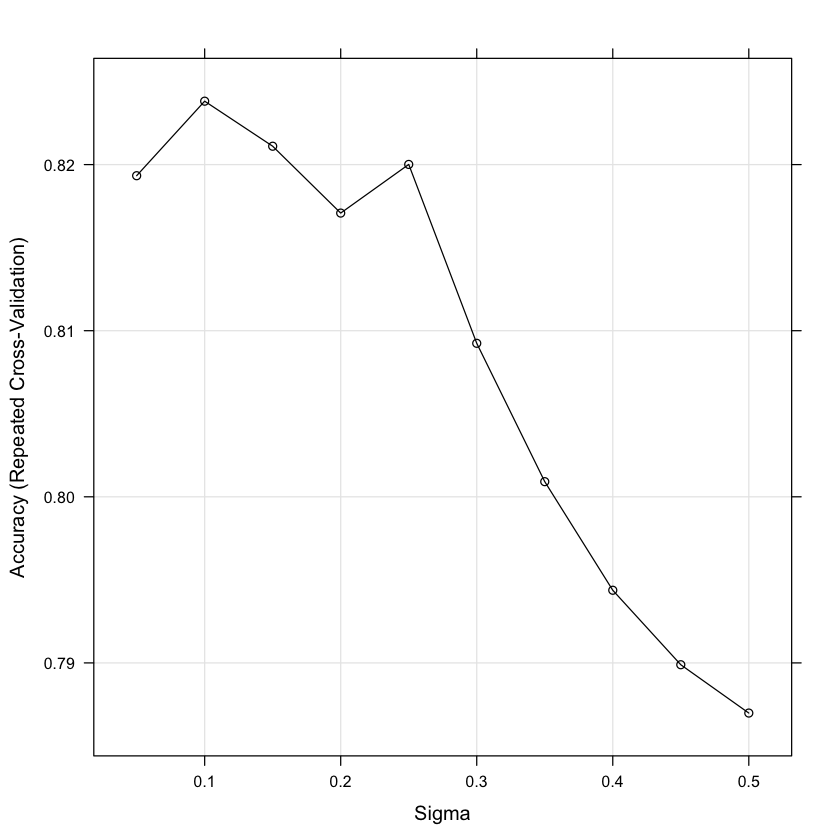

In [163]:
# Plot performance curves for all possible combinations of hyper-parameters
trellis.par.set(caretTheme())
plot(titanic.svm.model.cv)

In [168]:
titanic.svm.model.cv$finalModel

Least Squares Support Vector Machine object of class "lssvm" 

problem type : classification 
 parameter : tau = 0.01 

Gaussian Radial Basis kernel function. 
 Hyperparameter : sigma =  0.1 

Number of data points used for training : 53 
Training error : 0.164948 

In [169]:
?predict

In [215]:
# Retrain final model using complete dataset.  [Not sure if this is done for $finalModel in caret object]
library(kernlab)
#titanic.svm.model.final <- lssvm(Survived ~ ., data=training.set[, svm.model_spec], kernel='rbfdot',
#                                 kpar=list(sigma=selected.hypers[,'sigma']), tau=selected.hypers[,'tau'], scaled=TRUE)
titanic.svm.model.final <- lssvm(Survived ~ ., data=training.set[, svm.model_spec], kernel='rbfdot', scaled=TRUE)
titanic.svm.model.final

Using automatic sigma estimation (sigest) for RBF or laplace kernel 


Least Squares Support Vector Machine object of class "lssvm" 

problem type : classification 
 parameter : tau = 0.01 

Gaussian Radial Basis kernel function. 
 Hyperparameter : sigma =  0.262681580692625 

Number of data points used for training : 20 
Training error : 0.174136 

In [170]:
?lssvm

In [216]:
# Make make predictions on testing set using selected SVM model
#titanic.svm.predictions <- predict(titanic.svm.model.cv, 
#                                  newdata=testing.set, 
#                                  type="raw")
titanic.svm.predictions <- predict(titanic.svm.model.final, testing.set)

head(titanic.svm.predictions)
length(titanic.svm.predictions)

[1] Dead     Dead     Dead     Dead     Survived Dead    
Levels: Dead Survived

[1] 418

In [217]:
# Generate predictions list.
Survived<-as.numeric(titanic.svm.predictions == "Survived")
PassengerId<-testing.set$PassengerId
out.df<-data.frame(PassengerId, Survived)
write.csv(out.df, "Predictions/survival_predictions_dt50.csv", row.names=FALSE)

In [197]:
# NOTE: This cell works only if the model was trained with training.set <- Titanic.subtrain and 
# testing.set <- Titanic.subtest.  Will throw error if testing.set <- Titanic.test as there is no
# "Survived" feature in the dataframe.

# Build the confusion matrix
titanic.svm.confusion <- table(titanic.svm.predictions, testing.set$Survived)
print(titanic.svm.confusion)

# Accuracy
titanic.svm.accuracy <- sum(diag(titanic.svm.confusion)) / sum(titanic.svm.confusion)
cat("Accuracy: ", titanic.svm.accuracy)
# Precision
titanic.svm.precision <- titanic.svm.confusion[2,2] / sum(titanic.svm.confusion[2,])
cat("\nPrecision: ", titanic.svm.precision)
# Recall
titanic.svm.recall <- titanic.svm.confusion[2,2] / sum(titanic.svm.confusion[,2])
cat("\nRecall: ", titanic.svm.recall)
# F1 score
titanic.svm.F1 <- 2 * titanic.svm.precision * titanic.svm.recall / (titanic.svm.precision + titanic.svm.recall)
cat("\nF1-score: ", titanic.svm.F1)

                       
titanic.svm.predictions Dead Survived
               Dead      151       25
               Survived   15       77
Accuracy:  0.8507463
Precision:  0.8369565
Recall:  0.754902
F1-score:  0.7938144

## Code Residue (below)

In [ ]:
# Import train.csv into data frame, this is our test data for which the actual survived labels are unknown.
Titanic.test<-read.csv("Datasets/Titanic/test.csv", header=TRUE, sep=",")

# Make same modifications to Titanic.test that were made to Titanic.train above (except for "survived" column)
#Titanic.test$Survived <- as.factor(Titanic.test$Survived)
Titanic.test$Pclass <- as.factor(Titanic.test$Pclass)
# Insert median value for NAs in Age column
Titanic.test$Age[is.na(Titanic.test$Age)] <- median(Titanic.train$Age, na.rm=TRUE)
#levels(Titanic.test$Survived)<-c("Dead", "Survived")
levels(Titanic.test$Embarked)<-c("Unknown","Cherbourg", "Queenstown", "Southampton")
Titanic.test$Embarked[is.na(Titanic.test$Embarked)]<-mode
Titanic.test$FamilySize <- Titanic.test$SibSp + Titanic.test$Parch
Titanic.test$HasFamily <- as.factor(Titanic.test$FamilySize > 0)
Titanic.test$CabinType <- as.factor(substr(as.character(Titanic.test$Cabin),1,1))
Titanic.test$IsChild <- as.factor(Titanic.test$Age <= 12)
Titanic.test$IsSenior <- as.factor(Titanic.test$Age >= 50)

In [ ]:
# Generate decision tree model using the full set of training data from train.csv
titanic.tree.fullset<-rpart(as.formula(titanic.tree), 
                    data = Titanic.train, 
                    method="class", parms=parms_control,
                    control = train_control.best)

In [ ]:
Titanic.test.predictions <- predict(titanic.tree, Titanic.test[1,], type="class")
Titanic.test.predictions

In [ ]:
mod1<-c(0.66, 0.70, 0.65, 0.66, 0.72)
mod2<-c(0.79, 0.69, 0.70, 0.79, 0.90)
mod3<-c(0.74, 0.81, 0.84, 0.72, 0.69)
mod.df<-data.frame(mod1, mod2, mod3)

In [ ]:
library(ggplot2)

In [ ]:
p <- ggplot(mod.df)+geom_density()